In [1]:
import pandas as pd

email_data = pd.read_csv('C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/test_cleaned_category_email_dataset_machine_learning_model.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_25404\496921926.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  email_data = pd.read_csv('C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/test_cleaned_category_email_dataset_machine_learning_model.csv')


In [2]:
email_data['Combined_Text'] = email_data['Cleaned_Subject'].fillna('') + ' ' + email_data['Cleaned_Message'].fillna('')

In [4]:
email_data.columns

Index(['EmailID', 'From', 'To', 'DateTime', 'Subject', 'Message', 'Category',
       'Cleaned_Subject', 'Cleaned_Message', 'Combined_Text'],
      dtype='object')

In [3]:
email_data['Category'].value_counts()

Category
Work or Business Email                    61366
Finance & Transaction Email               41388
Personal Email                            35619
Meeting & Schedule Email                  28400
Legal & Contractual Email                 23001
Spam Email                                11807
IT Alerts & System Notifications Email    11347
Internal Policies & HR Updates Email       8837
Social Media Email                         7405
Promotions or Marketing Email              7379
Utilities Bill Email                       7323
Name: count, dtype: int64

In [ ]:
min_class_size = email_data['Category'].value_counts().min()
balanced_email_data = email_data.groupby('Category').apply(lambda x: x.sample(min_class_size, random_state=42)).reset_index(drop=True)

print(balanced_email_data['Category'].value_counts())

Category
Finance & Transaction Email               7323
IT Alerts & System Notifications Email    7323
Internal Policies & HR Updates Email      7323
Legal & Contractual Email                 7323
Meeting & Schedule Email                  7323
Personal Email                            7323
Promotions or Marketing Email             7323
Social Media Email                        7323
Spam Email                                7323
Utilities Bill Email                      7323
Work or Business Email                    7323
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_8088\1682075863.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_email_data = email_data.groupby('Category').apply(lambda x: x.sample(min_class_size, random_state=42)).reset_index(drop=True)


In [13]:
# Assume email_data contains your full dataset
# Column names: Combined_Text, Category, Cleaned_Subject, Cleaned_Message, etc.

def partial_undersample(df, target_col='Category', cap=15000):
    balanced_list = []
    for label, group in df.groupby(target_col):
        if len(group) > cap:
            sampled = group.sample(n=cap, random_state=42)
        else:
            sampled = group
        balanced_list.append(sampled)
    return pd.concat(balanced_list).reset_index(drop=True)

# Apply the undersampling
partially_balanced_email_data = partial_undersample(email_data, target_col='Category', cap=15000)

# Check the new distribution
print(partially_balanced_email_data['Category'].value_counts())

Category
Finance & Transaction Email               15000
Legal & Contractual Email                 15000
Meeting & Schedule Email                  15000
Personal Email                            15000
Work or Business Email                    15000
Spam Email                                11807
IT Alerts & System Notifications Email    11347
Internal Policies & HR Updates Email       8837
Social Media Email                         7405
Promotions or Marketing Email              7379
Utilities Bill Email                       7323
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer

#Split into Train and Test
X = partially_balanced_email_data['Combined_Text']
y = partially_balanced_email_data['Category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#BERT Embeddings
embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_train_embed = embedder.encode(X_train.tolist(), show_progress_bar=True)
X_test_embed = embedder.encode(X_test.tolist(), show_progress_bar=True)

In [6]:
np.save("X_train_embed.npy", X_train_embed)
np.save("X_test_embed.npy", X_test_embed)

# SVM

✅ Accuracy: 0.8344306738962045
📊 Classification Report:
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.72      0.73      0.72      3000
IT Alerts & System Notifications Email       0.89      0.93      0.91      2269
  Internal Policies & HR Updates Email       0.92      0.88      0.90      1767
             Legal & Contractual Email       0.77      0.83      0.80      3000
              Meeting & Schedule Email       0.84      0.83      0.84      3000
                        Personal Email       0.80      0.82      0.81      3000
         Promotions or Marketing Email       1.00      1.00      1.00      1476
                    Social Media Email       1.00      1.00      1.00      1481
                            Spam Email       0.92      0.90      0.91      2362
                  Utilities Bill Email       1.00      1.00      1.00      1465
                Work or Business Email       0.63      0.58    

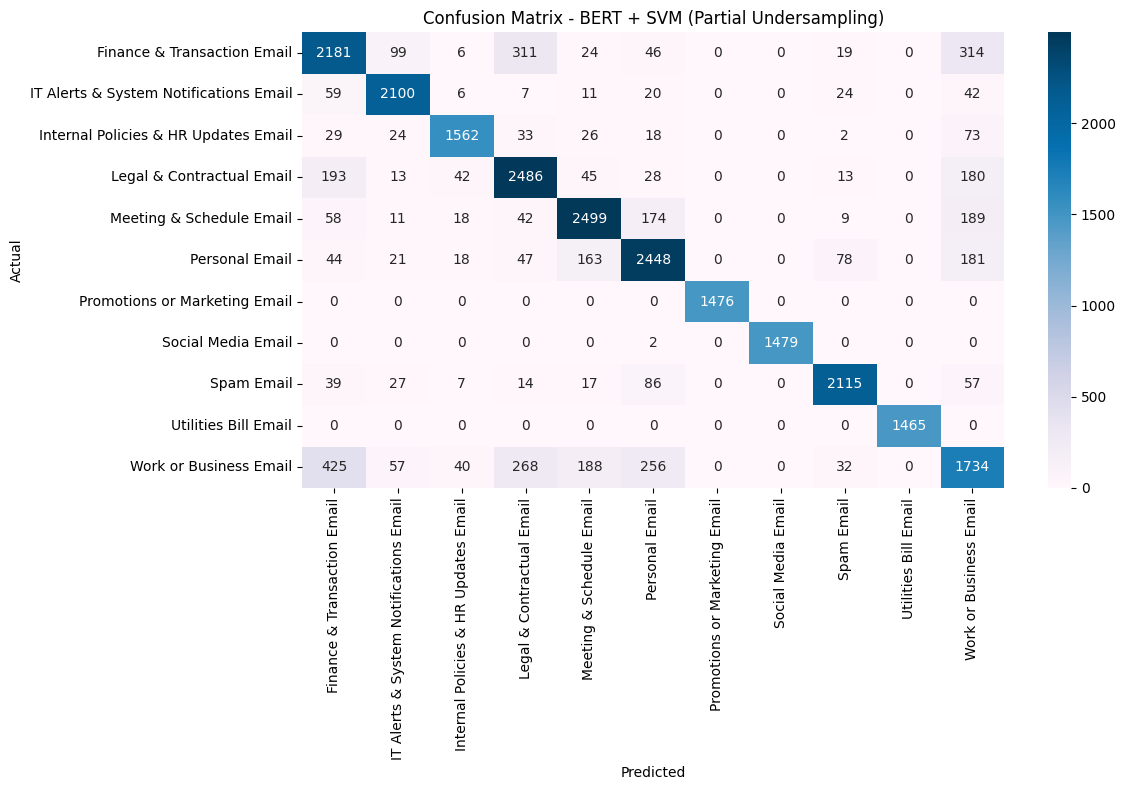

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# SVM Model
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_embed, y_train_encoded)

# Predictions
y_pred = svm_model.predict(X_test_embed)

# Evaluation
print("✅ Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuBu',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + SVM (Partial Undersampling)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [14]:
import joblib
import os
import numpy as np

save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

os.makedirs(save_dir, exist_ok=True)

joblib.dump(svm_model, os.path.join(save_dir, 'bert_svm_model.joblib')) 

['C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results\\bert_svm_model.joblib']

# Linear Regression

🧠 Training Logistic Regression...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Accuracy (BERT + Logistic Regression): 0.8277691711851278

📊 Classification Report:
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.70      0.71      0.71      3000
IT Alerts & System Notifications Email       0.88      0.92      0.90      2269
  Internal Policies & HR Updates Email       0.92      0.88      0.90      1767
             Legal & Contractual Email       0.77      0.82      0.79      3000
              Meeting & Schedule Email       0.83      0.83      0.83      3000
                        Personal Email       0.79      0.82      0.80      3000
         Promotions or Marketing Email       1.00      1.00      1.00      1476
                    Social Media Email       1.00      1.00      1.00      1481
                            Spam Email       0.91      0.89      0.90      2362
                  Utilities Bill Email       1.00      1.00      1.00      1465
                Work or Business 

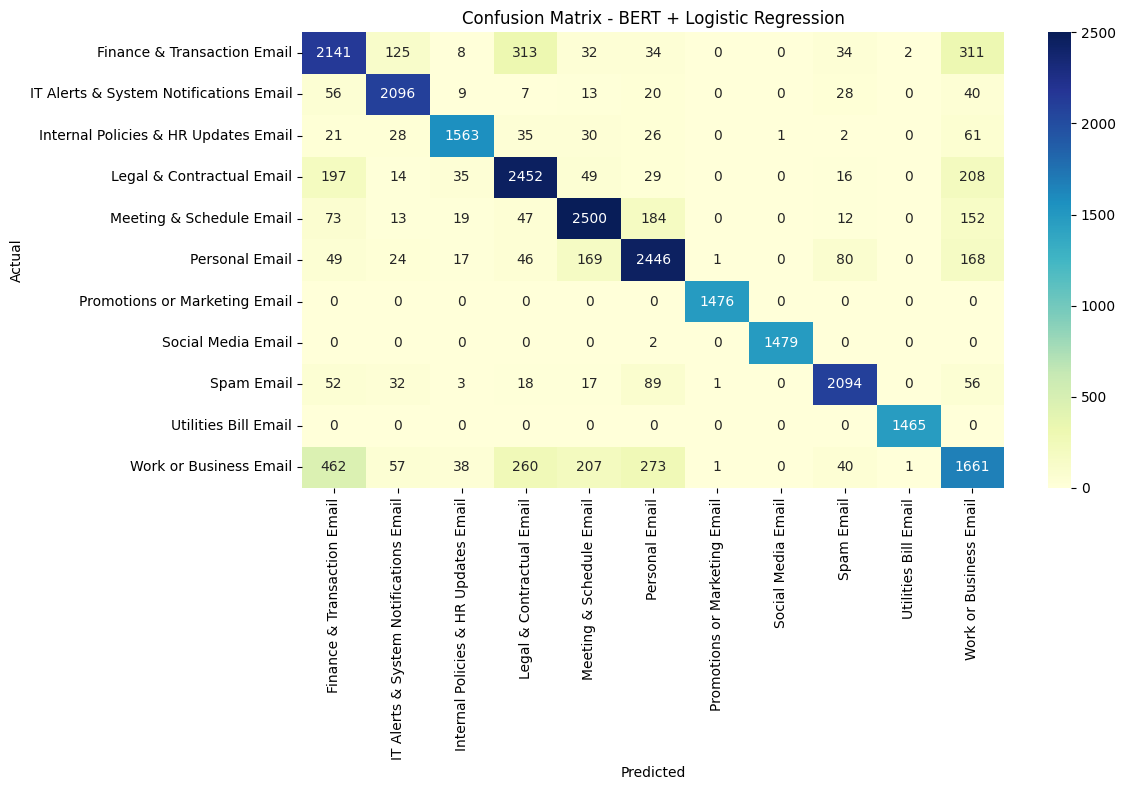

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
print("🧠 Training Logistic Regression...")
lr_model = LogisticRegression(
    solver='liblinear',
    multi_class='ovr',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train_embed, y_train_encoded)

#Evaluate the model
y_pred = lr_model.predict(X_test_embed)

print("✅ Accuracy (BERT + Logistic Regression):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# === Step 7: Plot confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [13]:
import joblib
import os
import numpy as np

save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

os.makedirs(save_dir, exist_ok=True)

joblib.dump(lr_model, os.path.join(save_dir, 'bert_lr_model.joblib')) 

['C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results\\bert_lr_model.joblib']

# Random Forest

🌲 Training Random Forest...
✅ Accuracy (BERT + Random Forest): 0.8202556158017041

📊 Classification Report:
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.73      0.72      0.73      3000
IT Alerts & System Notifications Email       0.98      0.86      0.92      2269
  Internal Policies & HR Updates Email       1.00      0.85      0.92      1767
             Legal & Contractual Email       0.75      0.84      0.79      3000
              Meeting & Schedule Email       0.84      0.80      0.82      3000
                        Personal Email       0.72      0.85      0.78      3000
         Promotions or Marketing Email       1.00      1.00      1.00      1476
                    Social Media Email       1.00      0.98      0.99      1481
                            Spam Email       0.98      0.83      0.90      2362
                  Utilities Bill Email       1.00      1.00      1.00      1465
           

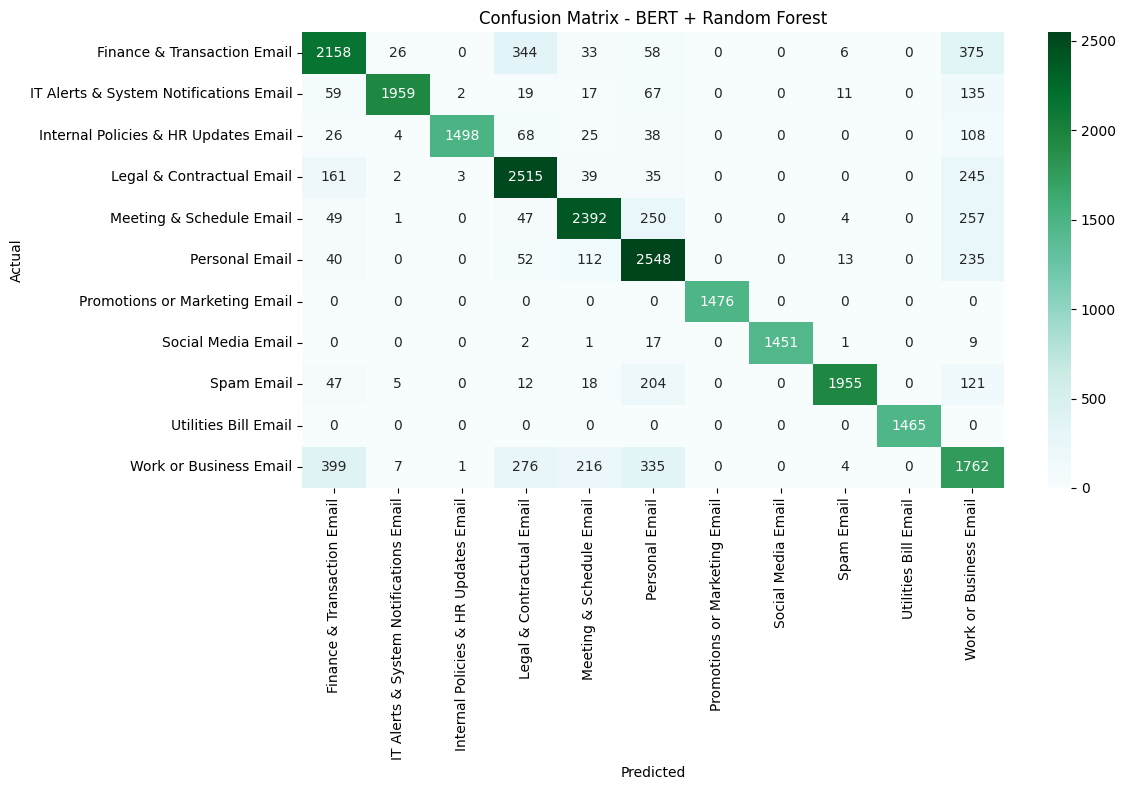

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest classifier
print("🌲 Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_embed, y_train_encoded)

# Evaluate
y_pred = rf_model.predict(X_test_embed)

print("✅ Accuracy (BERT + Random Forest):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuGn',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [12]:
import joblib
import os
import numpy as np

save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

os.makedirs(save_dir, exist_ok=True)

joblib.dump(rf_model, os.path.join(save_dir, 'bert_rf_model.joblib')) 

['C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results\\bert_rf_model.joblib']

# XG Boost

🚀 Training XGBoost model...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [17:12:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy (BERT + XGBoost): 0.841440743609605

📊 Classification Report:
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.75      0.75      0.75      3000
IT Alerts & System Notifications Email       0.95      0.91      0.93      2269
  Internal Policies & HR Updates Email       0.98      0.87      0.92      1767
             Legal & Contractual Email       0.78      0.83      0.81      3000
              Meeting & Schedule Email       0.85      0.84      0.84      3000
                        Personal Email       0.78      0.83      0.81      3000
         Promotions or Marketing Email       1.00      1.00      1.00      1476
                    Social Media Email       1.00      0.99      1.00      1481
                            Spam Email       0.96      0.88      0.92      2362
                  Utilities Bill Email       1.00      1.00      1.00      1465
                Work or Business Email       0

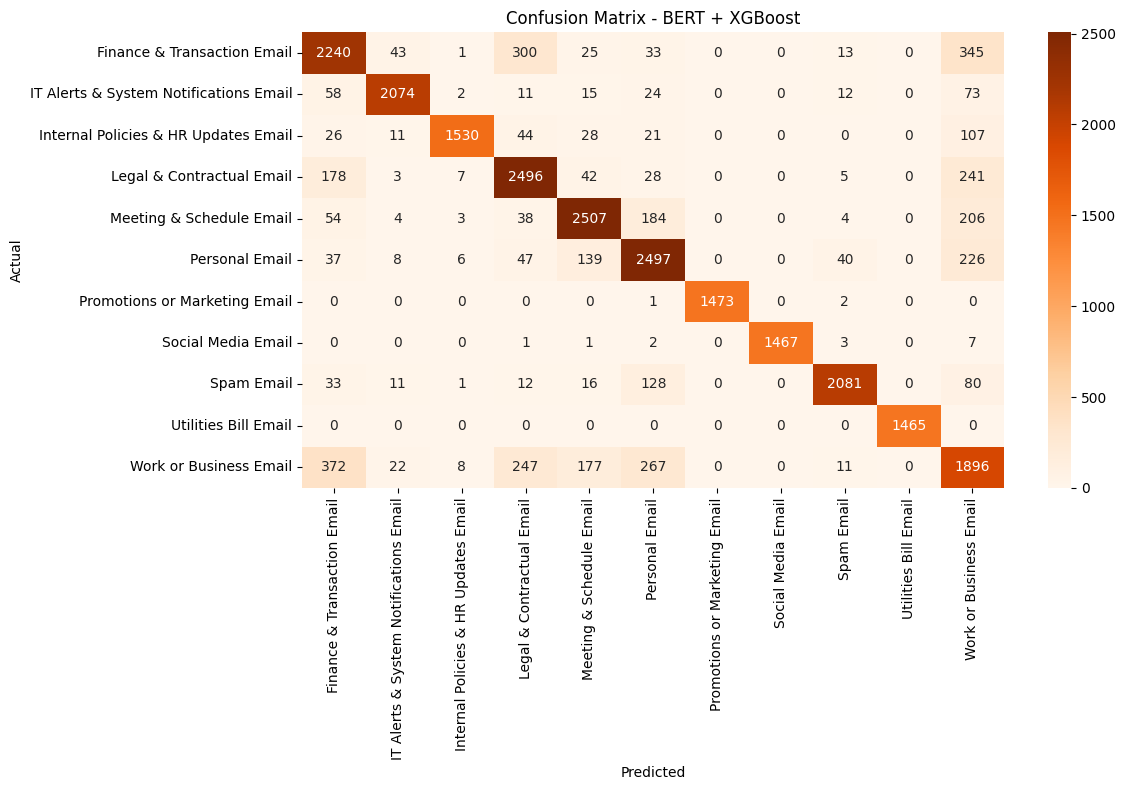

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb

# Train XGBoost model
print("🚀 Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    n_estimators=250,
    learning_rate=0.1,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    tree_method='hist',  # or 'gpu_hist' if using GPU
    random_state=42
)

xgb_model.fit(X_train_embed, y_train_encoded)

# 7: Predictions
y_pred = xgb_model.predict(X_test_embed)

# Evaluation
print("✅ Accuracy (BERT + XGBoost):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [17]:
import joblib
import os
import numpy as np

save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

os.makedirs(save_dir, exist_ok=True)

joblib.dump(xgb_model, os.path.join(save_dir, 'bert_xgb_model.joblib')) 

['C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results\\bert_xgb_model.joblib']

# Naive Bayes

✅ Accuracy (BERT + GaussianNB): 0.7633617350890782

📊 Classification Report:
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.64      0.66      0.65      3000
IT Alerts & System Notifications Email       0.93      0.80      0.86      2269
  Internal Policies & HR Updates Email       1.00      0.80      0.89      1767
             Legal & Contractual Email       0.76      0.74      0.75      3000
              Meeting & Schedule Email       0.84      0.74      0.79      3000
                        Personal Email       0.69      0.80      0.74      3000
         Promotions or Marketing Email       1.00      0.97      0.98      1476
                    Social Media Email       1.00      0.92      0.96      1481
                            Spam Email       0.97      0.69      0.81      2362
                  Utilities Bill Email       1.00      0.93      0.96      1465
                Work or Business Email    

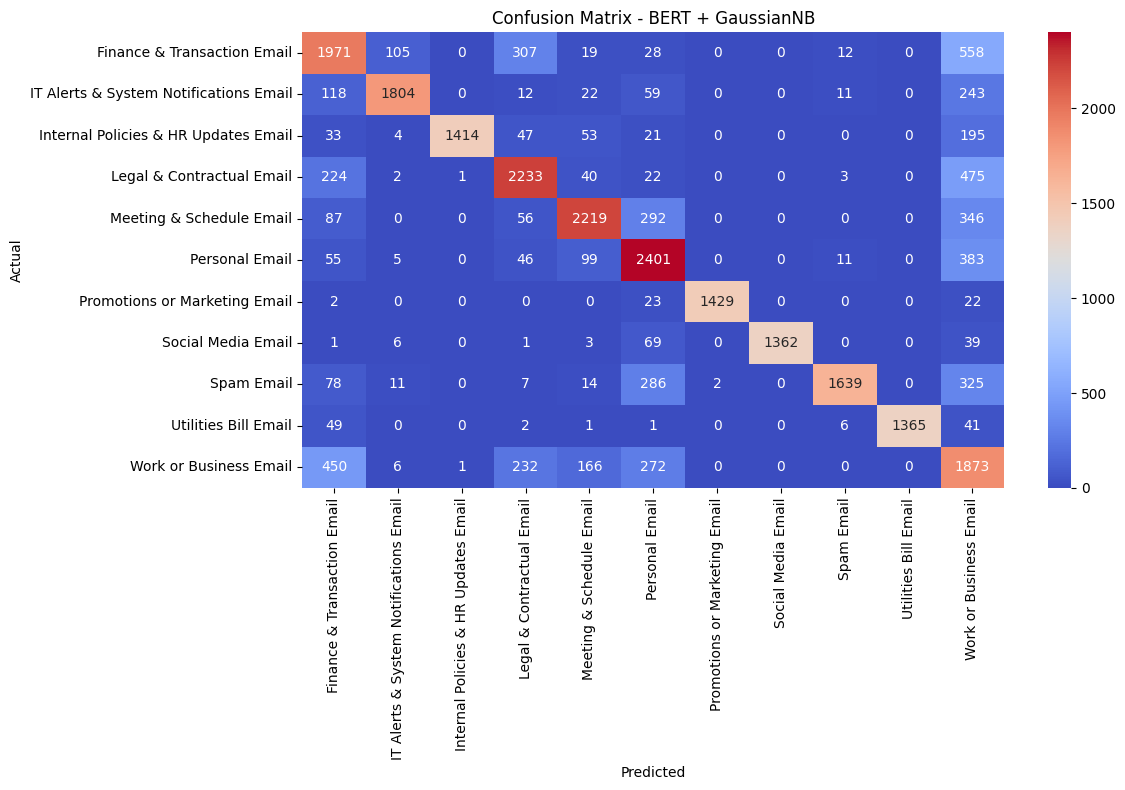

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize and train
nb_model = GaussianNB()
nb_model.fit(X_train_embed, y_train_encoded)

# Predict
y_pred = nb_model.predict(X_test_embed)

# Evaluate
print("✅ Accuracy (BERT + GaussianNB):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + GaussianNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
import joblib
import os
import numpy as np

# === Define your save directory ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

# === Create the directory if it doesn't exist ===
os.makedirs(save_dir, exist_ok=True)

# === Save individual models ===
joblib.dump(nb_model, os.path.join(save_dir, 'bert_nb_model.joblib'))        # Gaussian Naive Bayes

# Hybrid Model

🚀 Training Hybrid Voting Classifier...
✅ Accuracy (BERT + Hybrid Ensemble): 0.8440743609604957

📊 Classification Report:
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.75      0.75      0.75      3000
IT Alerts & System Notifications Email       0.94      0.92      0.93      2269
  Internal Policies & HR Updates Email       0.97      0.87      0.92      1767
             Legal & Contractual Email       0.78      0.84      0.81      3000
              Meeting & Schedule Email       0.84      0.84      0.84      3000
                        Personal Email       0.79      0.83      0.81      3000
         Promotions or Marketing Email       1.00      1.00      1.00      1476
                    Social Media Email       1.00      1.00      1.00      1481
                            Spam Email       0.95      0.89      0.92      2362
                  Utilities Bill Email       1.00      1.00      1.00      146

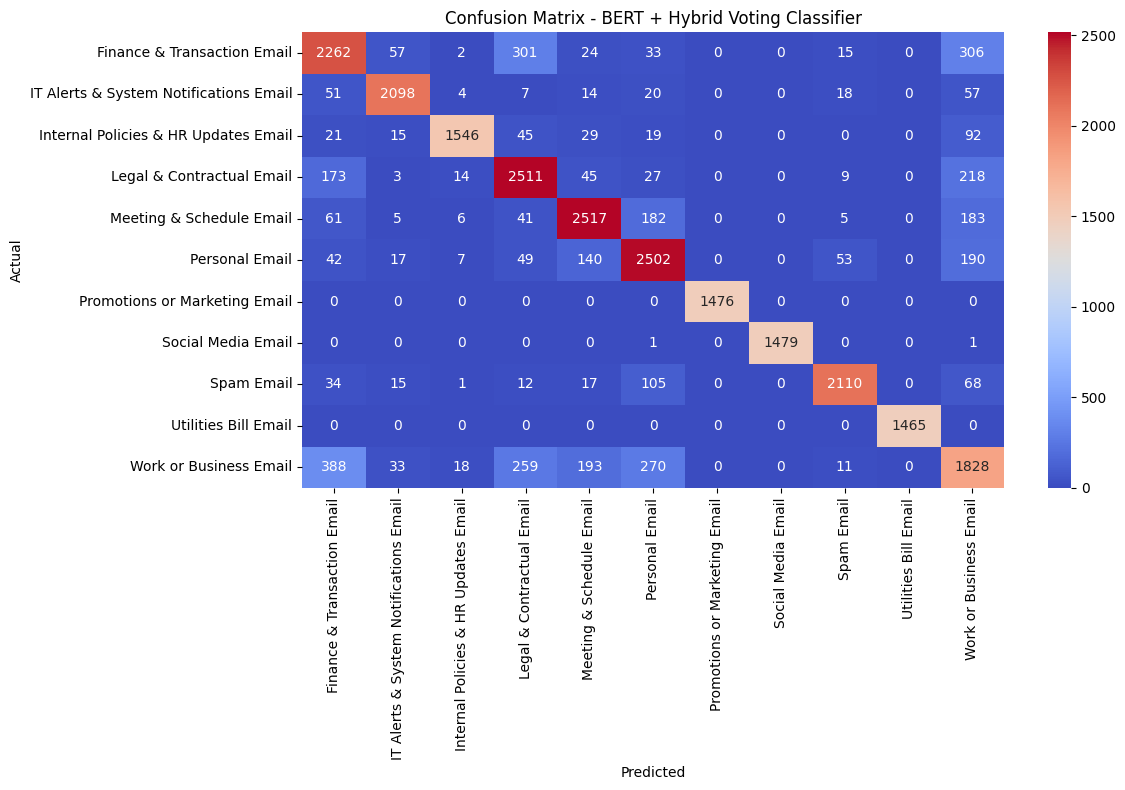

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('lr', lr_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft',         
    weights=[2, 2, 1, 3],   
    n_jobs=-1
)

# Fit hybrid model
print("🚀 Training Hybrid Voting Classifier...")
voting_model.fit(X_train_embed, y_train_encoded)

# Predict
y_pred = voting_model.predict(X_test_embed)

# Evaluate
print("✅ Accuracy (BERT + Hybrid Ensemble):", accuracy_score(y_test_encoded, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - BERT + Hybrid Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [20]:
import joblib
import os
import numpy as np

# === Define your save directory ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

# === Create the directory if it doesn't exist ===
os.makedirs(save_dir, exist_ok=True)

# === Save individual models ===
joblib.dump(voting_model, os.path.join(save_dir, 'bert_hybrid_soft_model.joblib'))  # Hybrid Soft Voting


['C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results\\bert_hybrid_soft_model.joblib']

# Save Model

In [23]:
import joblib
import os
import numpy as np

# === Define your save directory ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

# === Create the directory if it doesn't exist ===
os.makedirs(save_dir, exist_ok=True)

# === Save individual models ===
joblib.dump(lr_model, os.path.join(save_dir, 'bert_lr_model.joblib'))        # Logistic Regression
joblib.dump(rf_model, os.path.join(save_dir, 'bert_rf_model.joblib'))        # Random Forest
joblib.dump(svm_model, os.path.join(save_dir, 'bert_svm_model.joblib'))      # SVM
joblib.dump(xgb_model, os.path.join(save_dir, 'bert_xgb_model.joblib'))      # XGBoost
joblib.dump(nb_model, os.path.join(save_dir, 'bert_nb_model.joblib'))        # Gaussian Naive Bayes
joblib.dump(voting_model, os.path.join(save_dir, 'bert_hybrid_soft_model.joblib'))  # Hybrid Soft Voting

# === Save encoder and embedder ===
joblib.dump(label_encoder, os.path.join(save_dir, 'label_encoder.joblib'))

# Save BERT embedder model (to a subfolder)
embedder.save(os.path.join(save_dir, 'bert_embedder_model'))

# Model Comparison

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Split into Train and Test
X = partially_balanced_email_data['Combined_Text']
y = partially_balanced_email_data['Category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [15]:
import numpy as np

np.save(os.path.join(save_dir, 'y_test_encoded.npy'), y_test_encoded)
np.save(os.path.join(save_dir, 'y_train_encoded.npy'), y_train_encoded)

In [16]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer

# === Step 1: Set Paths ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

# Load BERT test embeddings
X_test_embed = np.load(os.path.join(save_dir, 'X_test_embed.npy'))

# Load label encoder
label_encoder = joblib.load(os.path.join(save_dir, 'label_encoder.joblib'))

# Load true labels (encoded)
y_test_encoded = np.load(os.path.join(save_dir, 'y_test_encoded.npy'))

# Define model paths
model_paths = {
    "Logistic Regression": os.path.join(save_dir, 'bert_lr_model.joblib'),
    "SVM": os.path.join(save_dir, 'bert_svm_model.joblib'),
    "Random Forest": os.path.join(save_dir, 'bert_rf_model.joblib'),
    "XGBoost": os.path.join(save_dir, 'bert_xgb_model.joblib'),
    "Hybrid Voting": os.path.join(save_dir, 'bert_hybrid_soft_model.joblib')
}

# === Step 2: Load models ===
models = {}
for name, path in model_paths.items():
    try:
        models[name] = joblib.load(path)
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")

# === Step 3: Evaluate each model ===
results = []

for name, model in models.items():
    try:
        y_pred = model.predict(X_test_embed)
        
        # Optional: skip models with wrong shape
        if len(y_pred) != len(y_test_encoded):
            raise ValueError(f"{name} prediction length mismatch.")

        acc = accuracy_score(y_test_encoded, y_pred)
        report = classification_report(y_test_encoded, y_pred, output_dict=True)

        results.append({
            "Model": name,
            "Accuracy": round(acc, 4),
            "Precision": round(report['macro avg']['precision'], 4),
            "Recall": round(report['macro avg']['recall'], 4),
            "F1-score": round(report['macro avg']['f1-score'], 4)
        })

    except Exception as e:
        print(f"❌ Error evaluating {name}: {e}")

# === Step 4: Display Results ===
comparison_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\n📊 Model Comparison (BERT Embeddings):")
print(comparison_df)


📊 Model Comparison (BERT Embeddings):
                 Model  Accuracy  Precision  Recall  F1-score
0        Hybrid Voting    0.8441     0.8760  0.8695    0.8723
1              XGBoost    0.8414     0.8774  0.8662    0.8711
2                  SVM    0.8344     0.8629  0.8624    0.8624
3  Logistic Regression    0.8278     0.8563  0.8570    0.8563
4        Random Forest    0.8203     0.8673  0.8464    0.8546


C:\Users\User\AppData\Local\Temp\ipykernel_6332\2840971977.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


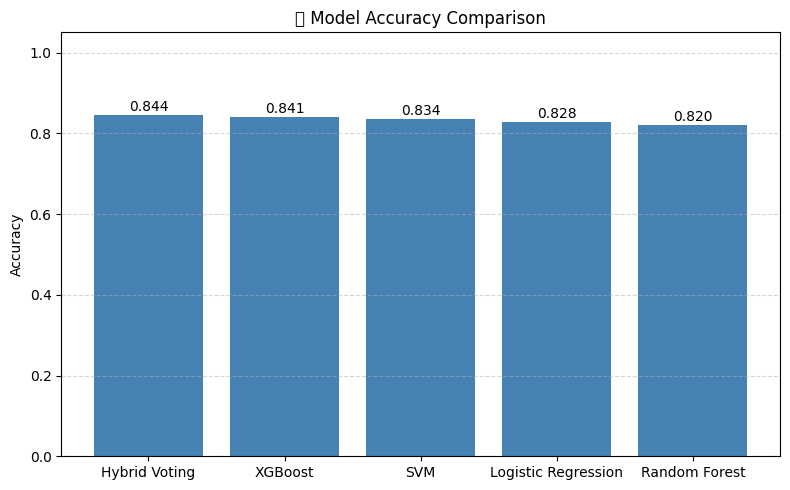

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
bars = plt.bar(comparison_df['Model'], comparison_df['Accuracy'], color='steelblue')

# Add accuracy labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}", ha='center', fontsize=10)

plt.title("🔍 Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

metrics = ['Precision', 'Recall', 'F1-score']
x = np.arange(len(comparison_df))  # label locations
width = 0.25  # bar width

plt.figure(figsize=(10, 6))

# Plot each metric
plt.bar(x - width, comparison_df['Precision'], width, label='Precision', color='mediumseagreen')
plt.bar(x, comparison_df['Recall'], width, label='Recall', color='gold')
plt.bar(x + width, comparison_df['F1-score'], width, label='F1-score', color='salmon')

# Labels and formatting
plt.ylabel('Score')
plt.title('📊 Model Precision, Recall, F1-score Comparison')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Test Data

Batches:   0%|          | 0/72 [00:00<?, ?it/s]

✅ Accuracy: 0.3156059285091543

📊 Classification Report:

                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.00      0.00      0.00         6
IT Alerts & System Notifications Email       0.87      0.94      0.90       272
             Legal & Contractual Email       0.00      0.00      0.00         1
              Meeting & Schedule Email       0.00      0.00      0.00         1
                        Personal Email       0.01      0.80      0.01         5
         Promotions or Marketing Email       1.00      0.17      0.28      1282
                    Social Media Email       0.97      0.40      0.57       434
                            Spam Email       0.00      0.00      0.00         1
                Work or Business Email       0.23      0.27      0.24       292

                             micro avg       0.32      0.32      0.32      2294
                             macro avg       0.34      0.29 

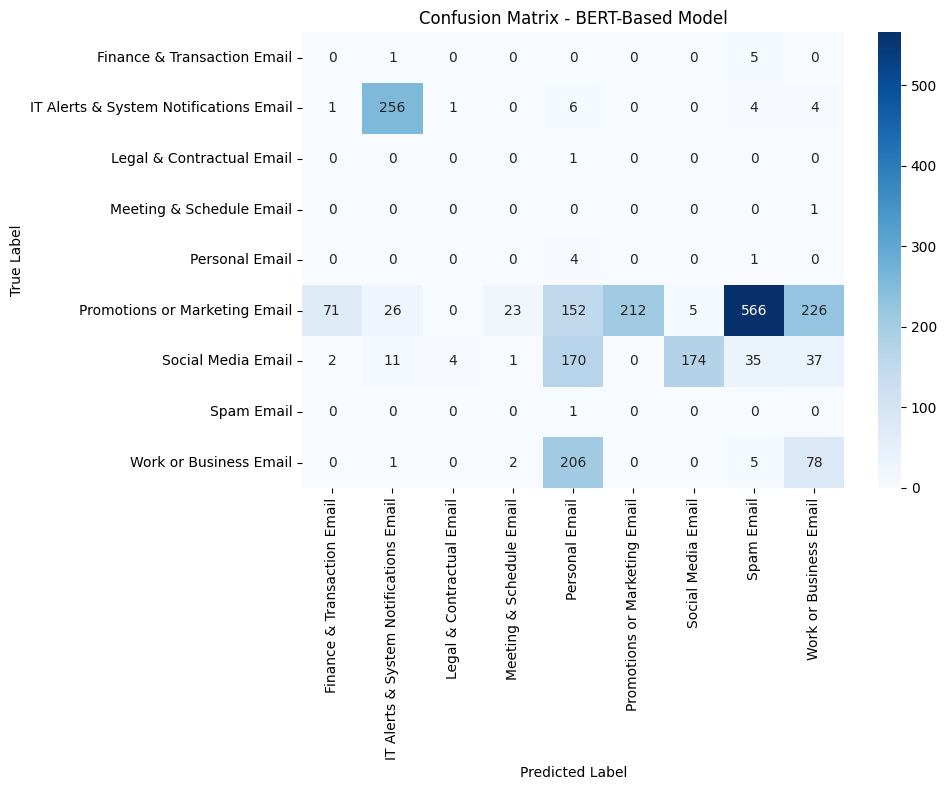

In [10]:
import pandas as pd
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Step 1: Load test data ===
test_data_path = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/emails_202504202357.csv"
df_test = pd.read_csv(test_data_path)

# === Step 2: Load saved model components ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

model_path = os.path.join(save_dir, 'bert_hybrid_soft_model.joblib')  # <-- Change this to 'bert_lr_model.joblib', etc.
encoder_path = os.path.join(save_dir, 'label_encoder.joblib')
embedder_path = os.path.join(save_dir, 'bert_embedder_model')

model = joblib.load(model_path)
label_encoder = joblib.load(encoder_path)
embedder = SentenceTransformer(embedder_path)

# === Step 3: Preprocess & Embed test data ===
df_test['Combined_Text'] = df_test['Subject'].fillna('') + ' ' + df_test['Message'].fillna('')
X_test_text = df_test['Combined_Text'].astype(str).tolist()
X_test_embed = embedder.encode(X_test_text, show_progress_bar=True)

# === Step 4: Encode true labels if available ===
if 'True_Category' in df_test.columns:
    y_true = label_encoder.transform(df_test['True_Category'])

# === Step 5: Predict
y_pred = model.predict(X_test_embed)
df_test['Predicted_Label'] = y_pred
df_test['Predicted_Category'] = label_encoder.inverse_transform(y_pred)

# === Step 6: Evaluation
if 'True_Category' in df_test.columns:
    print("✅ Accuracy:", accuracy_score(y_true, y_pred))

    unique_classes = np.unique(y_true)
    target_names = label_encoder.inverse_transform(unique_classes)

    print("\n📊 Classification Report:\n")
    print(classification_report(y_true, y_pred, labels=unique_classes, target_names=target_names))

    # === Step 7: Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d",
                xticklabels=target_names, yticklabels=target_names, cmap="Blues")
    plt.title("Confusion Matrix - BERT-Based Model")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# Real World + Synthetic Data

Batches:   0%|          | 0/385 [00:00<?, ?it/s]


🚀 Evaluating: Logistic Regression
✅ Accuracy: 0.8840
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.94      0.99      0.97       939
IT Alerts & System Notifications Email       0.95      0.99      0.97      1168
  Internal Policies & HR Updates Email       0.98      1.00      0.99       965
             Legal & Contractual Email       0.95      1.00      0.98       956
              Meeting & Schedule Email       0.94      0.99      0.96       929
                        Personal Email       0.67      1.00      0.81       951
         Promotions or Marketing Email       1.00      0.63      0.77      2171
                    Social Media Email       0.97      0.87      0.92      1397
                            Spam Email       0.62      1.00      0.76       790
                  Utilities Bill Email       1.00      1.00      1.00       785
                Work or Business Email       0.81      0.68      

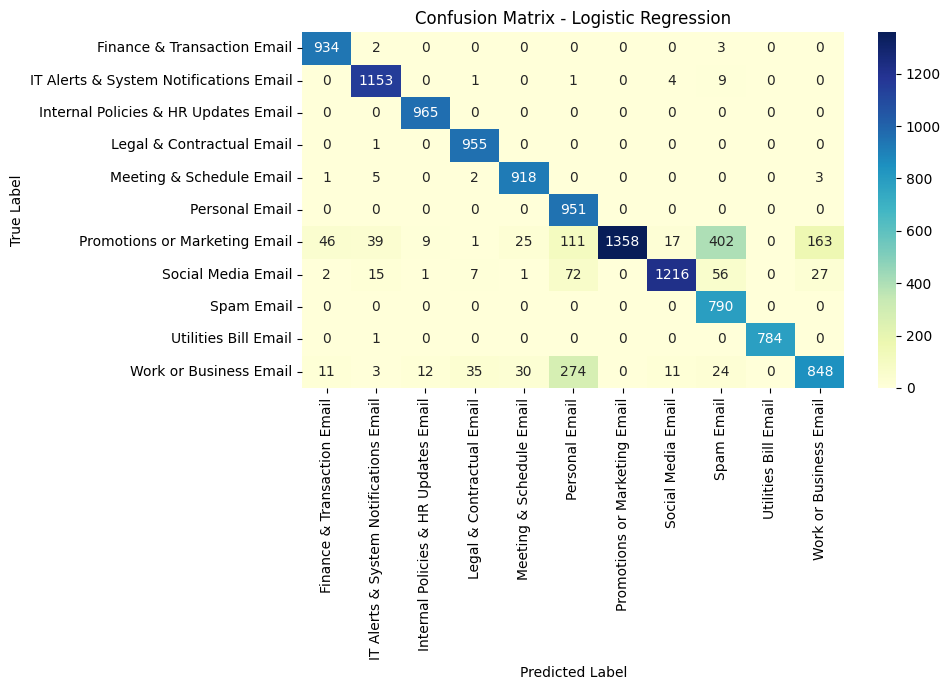


🚀 Evaluating: SVM
✅ Accuracy: 0.8406
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.94      0.99      0.97       939
IT Alerts & System Notifications Email       0.93      0.98      0.96      1168
  Internal Policies & HR Updates Email       0.98      1.00      0.99       965
             Legal & Contractual Email       0.96      1.00      0.98       956
              Meeting & Schedule Email       0.95      0.96      0.96       929
                        Personal Email       0.65      1.00      0.78       951
         Promotions or Marketing Email       1.00      0.46      0.63      2171
                    Social Media Email       0.99      0.79      0.88      1397
                            Spam Email       0.44      0.99      0.61       790
                  Utilities Bill Email       1.00      0.95      0.97       785
                Work or Business Email       0.84      0.70      0.77      1248



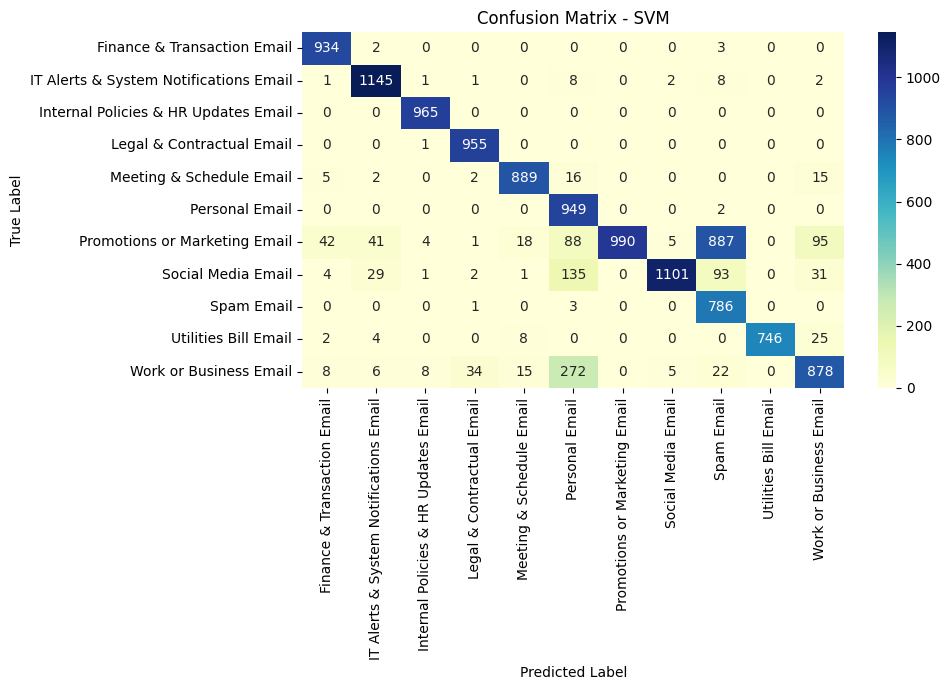


🚀 Evaluating: Random Forest
✅ Accuracy: 0.8032
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.87      1.00      0.93       939
IT Alerts & System Notifications Email       0.99      0.82      0.90      1168
  Internal Policies & HR Updates Email       1.00      0.99      0.99       965
             Legal & Contractual Email       0.98      0.99      0.99       956
              Meeting & Schedule Email       0.90      0.96      0.93       929
                        Personal Email       0.41      1.00      0.58       951
         Promotions or Marketing Email       1.00      0.47      0.64      2171
                    Social Media Email       0.99      0.73      0.84      1397
                            Spam Email       0.83      0.99      0.91       790
                  Utilities Bill Email       1.00      0.51      0.67       785
                Work or Business Email       0.62      0.82      0.70  

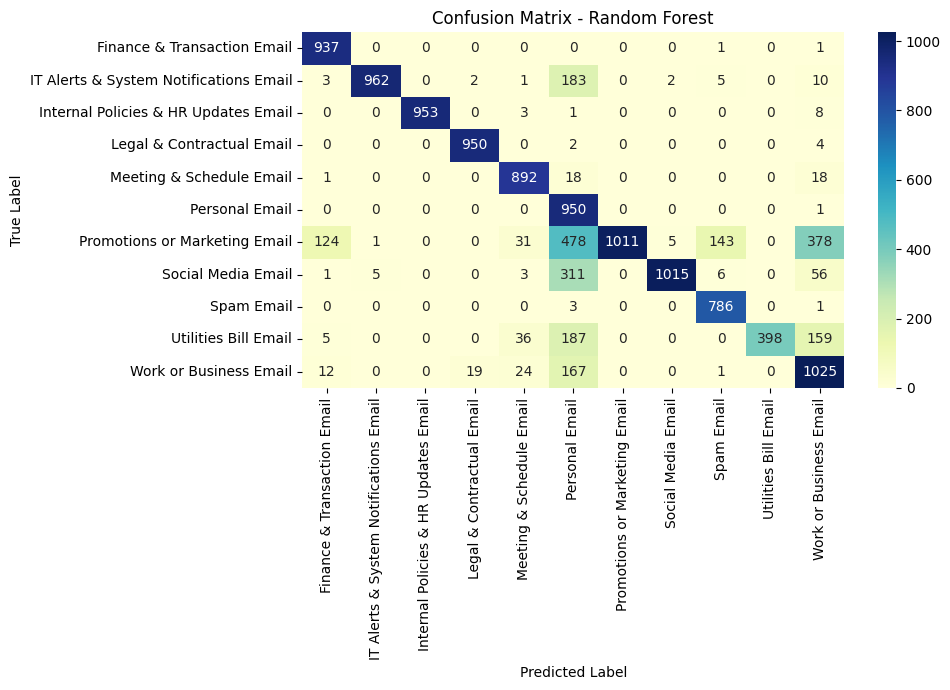


🚀 Evaluating: XGBoost
✅ Accuracy: 0.8035
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.84      1.00      0.91       939
IT Alerts & System Notifications Email       0.79      0.98      0.87      1168
  Internal Policies & HR Updates Email       1.00      1.00      1.00       965
             Legal & Contractual Email       0.97      1.00      0.98       956
              Meeting & Schedule Email       0.85      0.98      0.91       929
                        Personal Email       0.53      1.00      0.69       951
         Promotions or Marketing Email       1.00      0.44      0.61      2171
                    Social Media Email       0.99      0.60      0.75      1397
                            Spam Email       0.66      1.00      0.79       790
                  Utilities Bill Email       1.00      0.48      0.65       785
                Work or Business Email       0.69      0.85      0.76      12

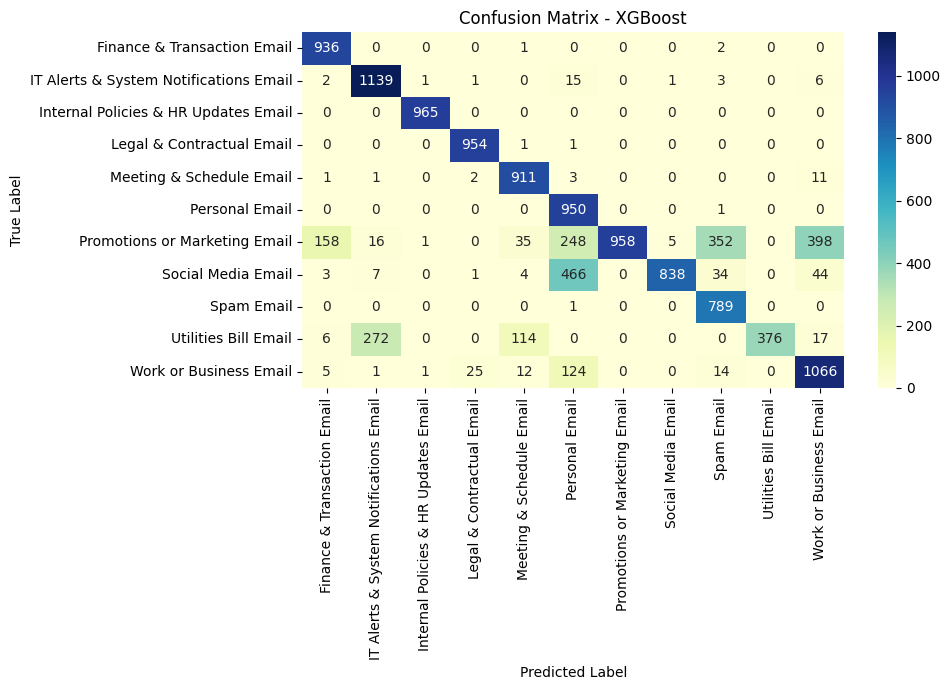


🚀 Evaluating: Naive Bayes
✅ Accuracy: 0.6924
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.93      0.94      0.94       939
IT Alerts & System Notifications Email       0.73      0.79      0.76      1168
  Internal Policies & HR Updates Email       1.00      0.68      0.81       965
             Legal & Contractual Email       0.99      0.98      0.98       956
              Meeting & Schedule Email       0.81      0.93      0.87       929
                        Personal Email       0.38      1.00      0.55       951
         Promotions or Marketing Email       1.00      0.24      0.39      2171
                    Social Media Email       1.00      0.41      0.58      1397
                            Spam Email       0.54      0.97      0.69       790
                  Utilities Bill Email       1.00      0.49      0.65       785
                Work or Business Email       0.52      0.84      0.65    

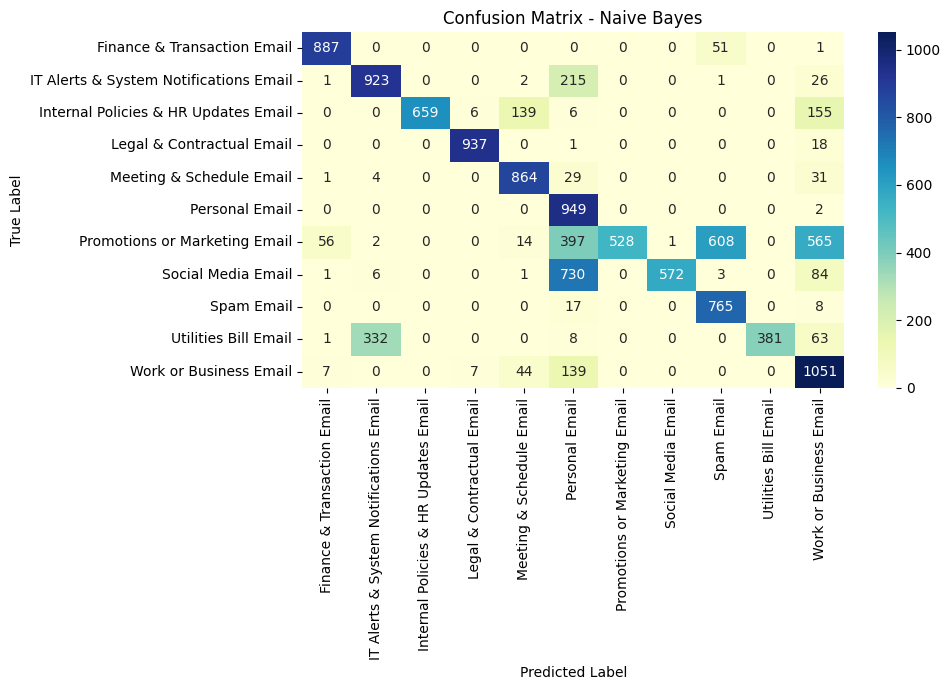


🚀 Evaluating: Hybrid
✅ Accuracy: 0.8545
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.92      0.99      0.96       939
IT Alerts & System Notifications Email       0.87      0.98      0.92      1168
  Internal Policies & HR Updates Email       1.00      1.00      1.00       965
             Legal & Contractual Email       0.97      1.00      0.98       956
              Meeting & Schedule Email       0.96      0.98      0.97       929
                        Personal Email       0.63      1.00      0.77       951
         Promotions or Marketing Email       1.00      0.51      0.67      2171
                    Social Media Email       0.99      0.81      0.89      1397
                            Spam Email       0.56      1.00      0.72       790
                  Utilities Bill Email       1.00      0.83      0.90       785
                Work or Business Email       0.77      0.78      0.78      124

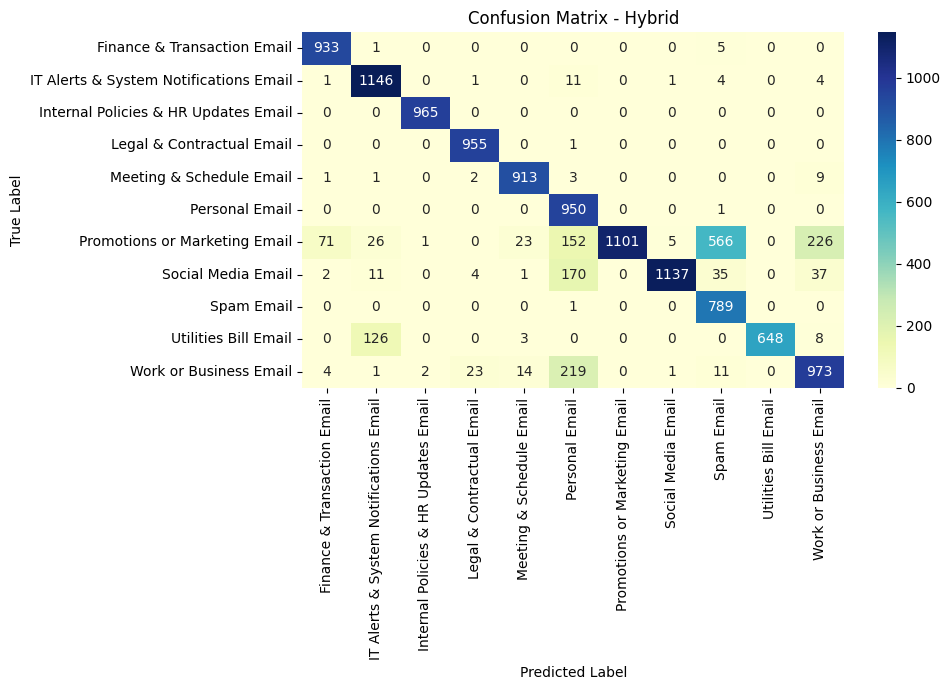


📊 Model Comparison Summary:
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.883974   0.894448  0.922101  0.896280
5               Hybrid  0.854541   0.879672  0.898213  0.870174
1                  SVM  0.840556   0.879817  0.892881  0.861951
3              XGBoost  0.803480   0.847094  0.847497  0.812179
2        Random Forest  0.803236   0.872369  0.843401  0.825564
4          Naive Bayes  0.692414   0.808727  0.752211  0.715469


C:\Users\User\AppData\Local\Temp\ipykernel_8088\2725183712.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
C:\Users\User\AppData\Local\Temp\ipykernel_8088\2725183712.py:93: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


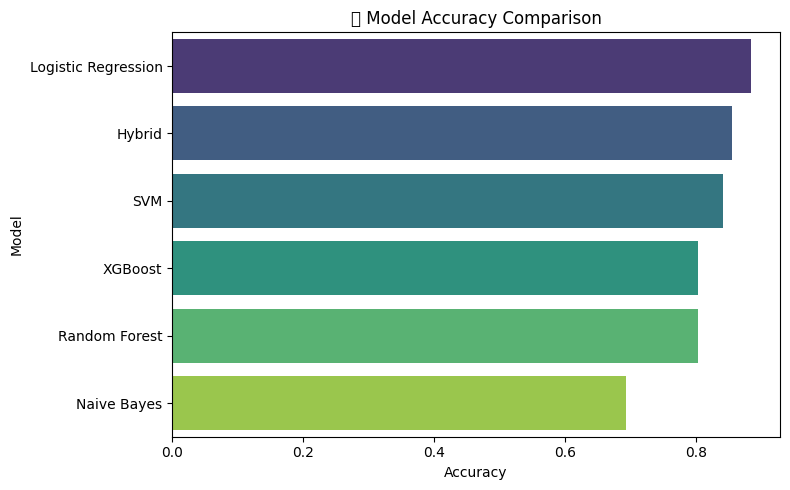

In [25]:
import pandas as pd
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Step 1: Load test data ===
test_data_path = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/rewritten_batch1_emails_polished_testing_data.csv"
df_test = pd.read_csv(test_data_path)

# === Step 2: Load label encoder and BERT embedder ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"
encoder_path = os.path.join(save_dir, 'label_encoder.joblib')
embedder_path = os.path.join(save_dir, 'bert_embedder_model')

label_encoder = joblib.load(encoder_path)
embedder = SentenceTransformer(embedder_path)

# === Step 3: Preprocess and Embed ===
df_test['Combined_Text'] = df_test['Subject'].fillna('') + ' ' + df_test['Message'].fillna('')
X_test_text = df_test['Combined_Text'].astype(str).tolist()
X_test_embed = embedder.encode(X_test_text, show_progress_bar=True)

# === Step 4: Encode true labels if available ===
if 'True_Category' in df_test.columns:
    y_true = label_encoder.transform(df_test['True_Category'])

# === Step 5: Define all BERT-based model paths ===
model_paths = {
    "Logistic Regression": os.path.join(save_dir, 'bert_lr_model.joblib'),
    "SVM": os.path.join(save_dir, 'bert_svm_model.joblib'),
    "Random Forest": os.path.join(save_dir, 'bert_rf_model.joblib'),
    "XGBoost": os.path.join(save_dir, 'bert_xgb_model.joblib'),
    "Naive Bayes": os.path.join(save_dir, 'bert_nb_model.joblib'),
    "Hybrid": os.path.join(save_dir, 'bert_hybrid_soft_model.joblib')
}

# === Step 6: Evaluate All Models ===
comparison_results = []

for model_name, model_path in model_paths.items():
    print(f"\n🚀 Evaluating: {model_name}")
    model = joblib.load(model_path)
    y_pred = model.predict(X_test_embed)

    # ✅ Identify present classes in test set
    unique_labels = np.unique(y_true)
    target_names = label_encoder.inverse_transform(unique_labels)

    # ✅ Metrics
    acc = accuracy_score(y_true, y_pred)
    report_dict = classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names, output_dict=True)

    # ✅ Append to summary
    comparison_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": report_dict["macro avg"]["precision"],
        "Recall": report_dict["macro avg"]["recall"],
        "F1-Score": report_dict["macro avg"]["f1-score"]
    })

    # ✅ Print report
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names))

    # ✅ Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d",
                xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# === Step 7: Compare All Models ===
comparison_df = pd.DataFrame(comparison_results).sort_values(by="Accuracy", ascending=False)

print("\n📊 Model Comparison Summary:")
print(comparison_df)

# === Step 8: Plot Comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
plt.title("📈 Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

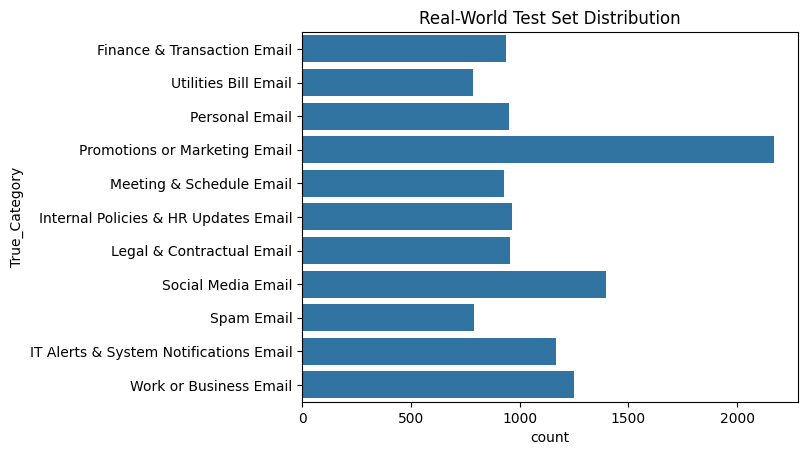

In [26]:
df_test['True_Category'].value_counts()
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(y='True_Category', data=df_test)
plt.title('Real-World Test Set Distribution')
plt.show()

# Additional

# Real Sample Emails

Batches:   0%|          | 0/72 [00:00<?, ?it/s]


🚀 Evaluating: SVM
✅ Accuracy: 0.2332
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.02      0.17      0.04         6
IT Alerts & System Notifications Email       0.77      0.94      0.85       272
             Legal & Contractual Email       0.00      0.00      0.00         1
              Meeting & Schedule Email       0.00      0.00      0.00         1
                        Personal Email       0.01      0.60      0.01         5
         Promotions or Marketing Email       1.00      0.08      0.15      1282
                    Social Media Email       0.97      0.32      0.48       434
                            Spam Email       0.00      1.00      0.00         1
                Work or Business Email       0.21      0.12      0.15       292

                             micro avg       0.23      0.23      0.23      2294
                             macro avg       0.33      0.36      0.19      2294


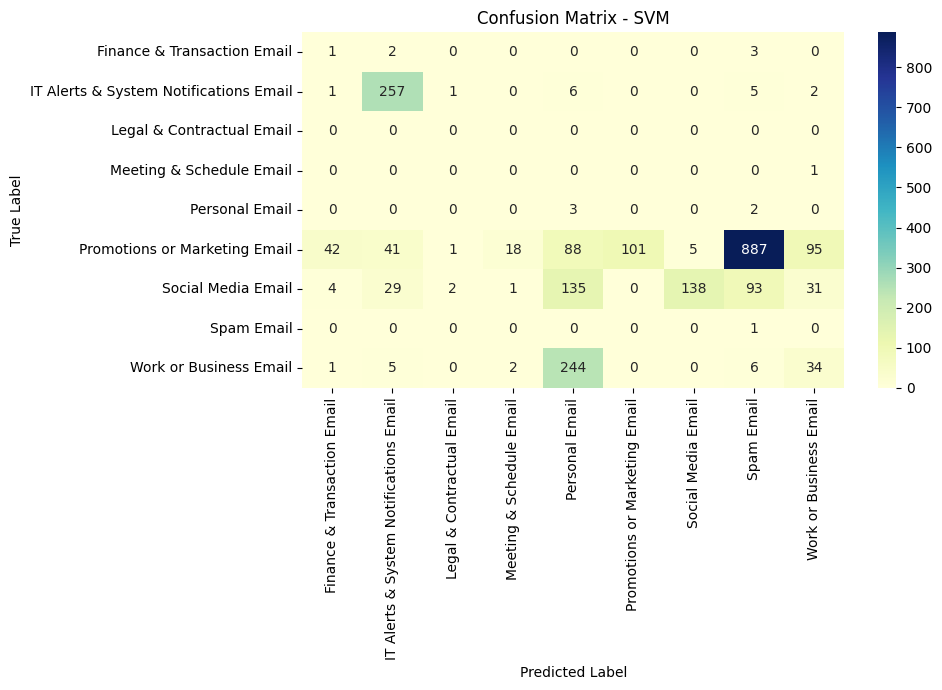


🚀 Evaluating: Logistic Regression
✅ Accuracy: 0.4412
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.02      0.17      0.04         6
IT Alerts & System Notifications Email       0.81      0.95      0.88       272
             Legal & Contractual Email       0.00      0.00      0.00         1
              Meeting & Schedule Email       0.00      0.00      0.00         1
                        Personal Email       0.01      1.00      0.02         5
         Promotions or Marketing Email       1.00      0.37      0.54      1282
                    Social Media Email       0.93      0.58      0.72       434
                            Spam Email       0.00      1.00      0.00         1
                Work or Business Email       0.11      0.08      0.09       292

                             micro avg       0.44      0.44      0.44      2294
                             macro avg       0.32      0.46     

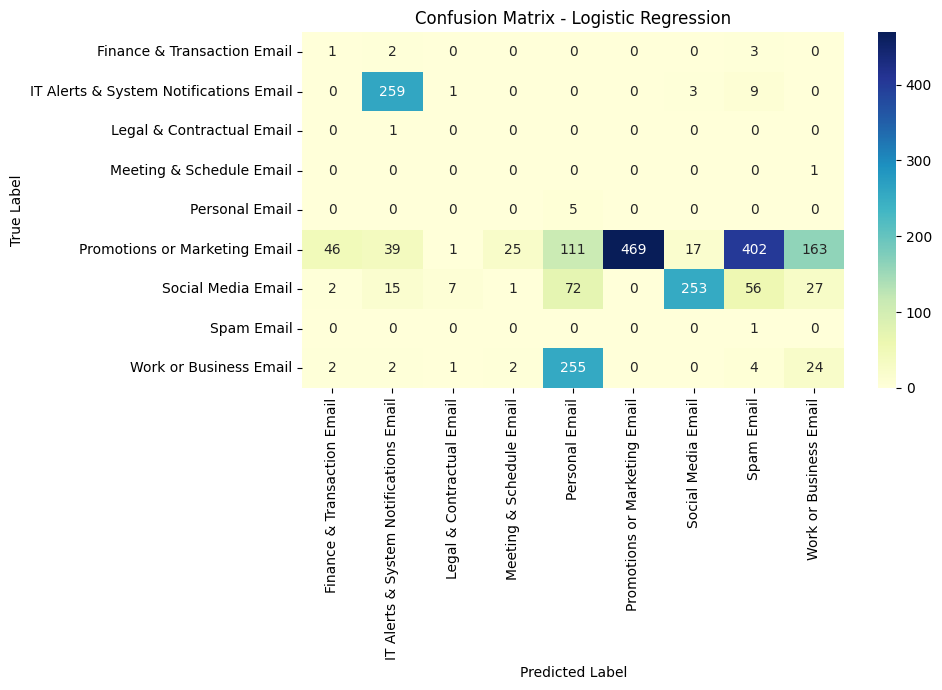


🚀 Evaluating: Random Forest
✅ Accuracy: 0.2188
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.03      0.67      0.06         6
IT Alerts & System Notifications Email       0.92      0.27      0.42       272
             Legal & Contractual Email       0.00      0.00      0.00         1
              Meeting & Schedule Email       0.00      0.00      0.00         1
                        Personal Email       0.00      0.80      0.01         5
         Promotions or Marketing Email       1.00      0.10      0.19      1282
                    Social Media Email       0.95      0.34      0.50       434
                            Spam Email       0.00      0.00      0.00         1
                Work or Business Email       0.24      0.48      0.32       292

                              accuracy                           0.22      2294
                             macro avg       0.35      0.30      0.17 

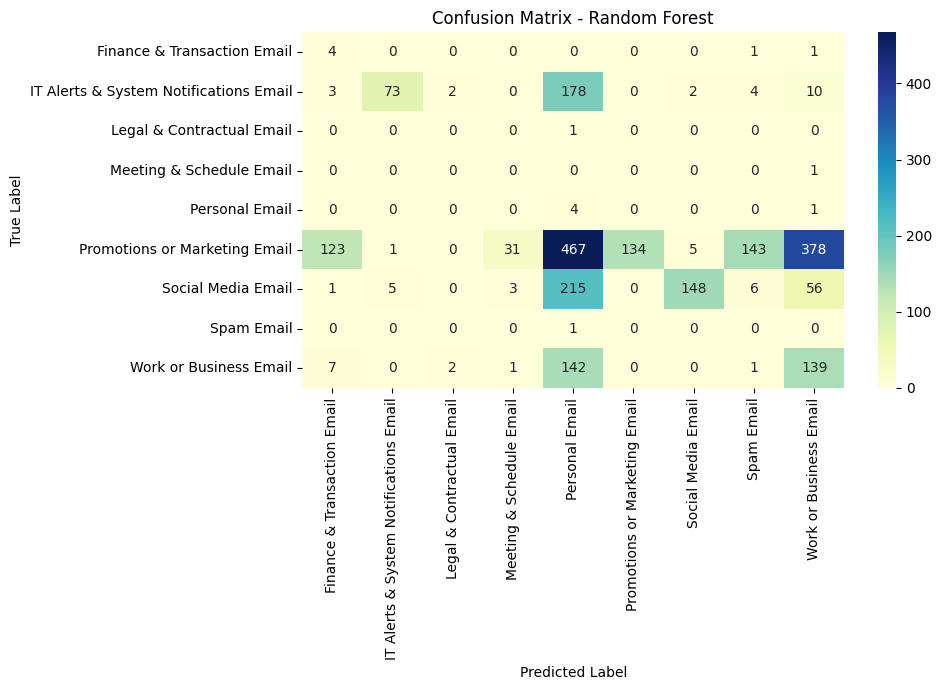


🚀 Evaluating: XGBoost
✅ Accuracy: 0.2825
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.02      0.50      0.03         6
IT Alerts & System Notifications Email       0.91      0.93      0.92       272
             Legal & Contractual Email       0.00      0.00      0.00         1
              Meeting & Schedule Email       0.00      0.00      0.00         1
                        Personal Email       0.01      0.80      0.01         5
         Promotions or Marketing Email       1.00      0.05      0.10      1282
                    Social Media Email       0.97      0.37      0.53       434
                            Spam Email       0.00      0.00      0.00         1
                Work or Business Email       0.26      0.55      0.36       292

                             micro avg       0.28      0.28      0.28      2294
                             macro avg       0.35      0.36      0.22      2

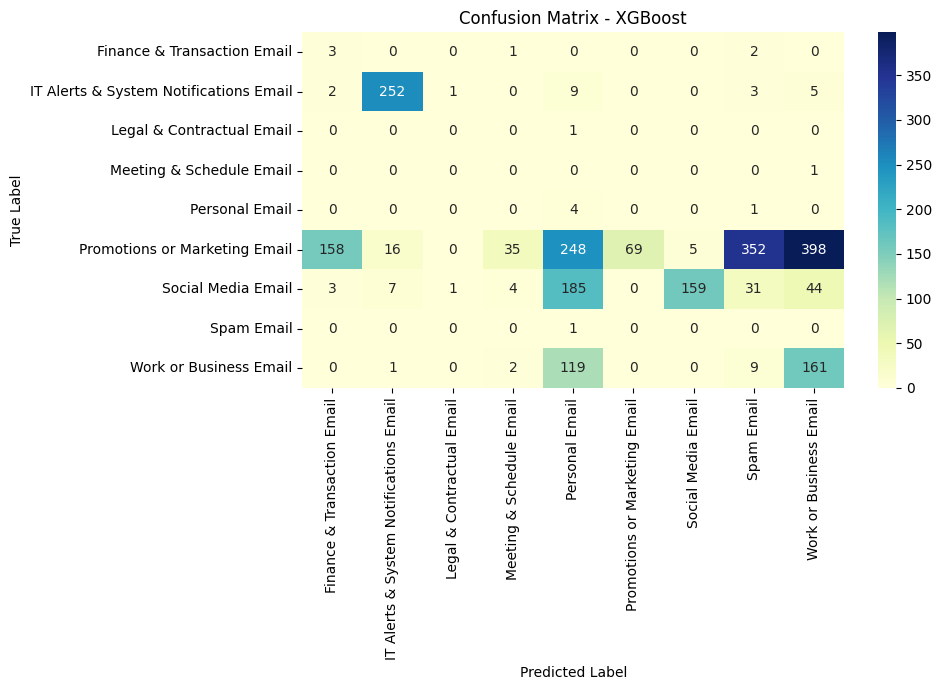


🚀 Evaluating: Naive Bayes
✅ Accuracy: 0.1879
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.06      0.67      0.11         6
IT Alerts & System Notifications Email       0.90      0.26      0.40       272
             Legal & Contractual Email       0.00      0.00      0.00         1
              Meeting & Schedule Email       0.00      0.00      0.00         1
                        Personal Email       0.00      0.60      0.01         5
         Promotions or Marketing Email       1.00      0.06      0.12      1282
                    Social Media Email       0.99      0.22      0.36       434
                            Spam Email       0.00      0.00      0.00         1
                Work or Business Email       0.21      0.60      0.31       292

                              accuracy                           0.19      2294
                             macro avg       0.35      0.27      0.15   

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.

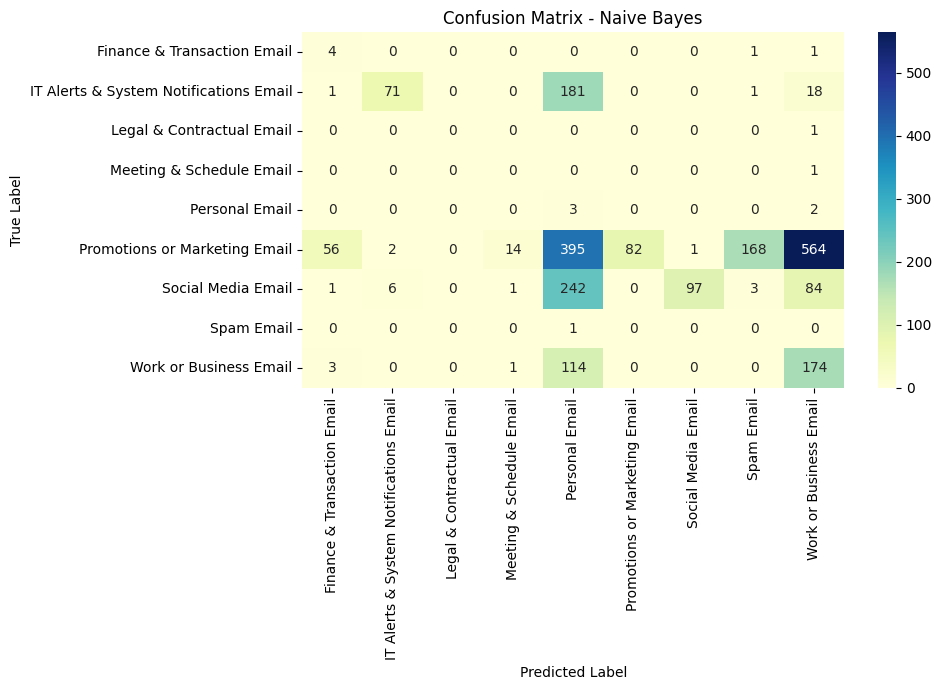


🚀 Evaluating: Hybrid
✅ Accuracy: 0.3156
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.00      0.00      0.00         6
IT Alerts & System Notifications Email       0.87      0.94      0.90       272
             Legal & Contractual Email       0.00      0.00      0.00         1
              Meeting & Schedule Email       0.00      0.00      0.00         1
                        Personal Email       0.01      0.80      0.01         5
         Promotions or Marketing Email       1.00      0.17      0.28      1282
                    Social Media Email       0.97      0.40      0.57       434
                            Spam Email       0.00      0.00      0.00         1
                Work or Business Email       0.23      0.27      0.24       292

                             micro avg       0.32      0.32      0.32      2294
                             macro avg       0.34      0.29      0.22      22

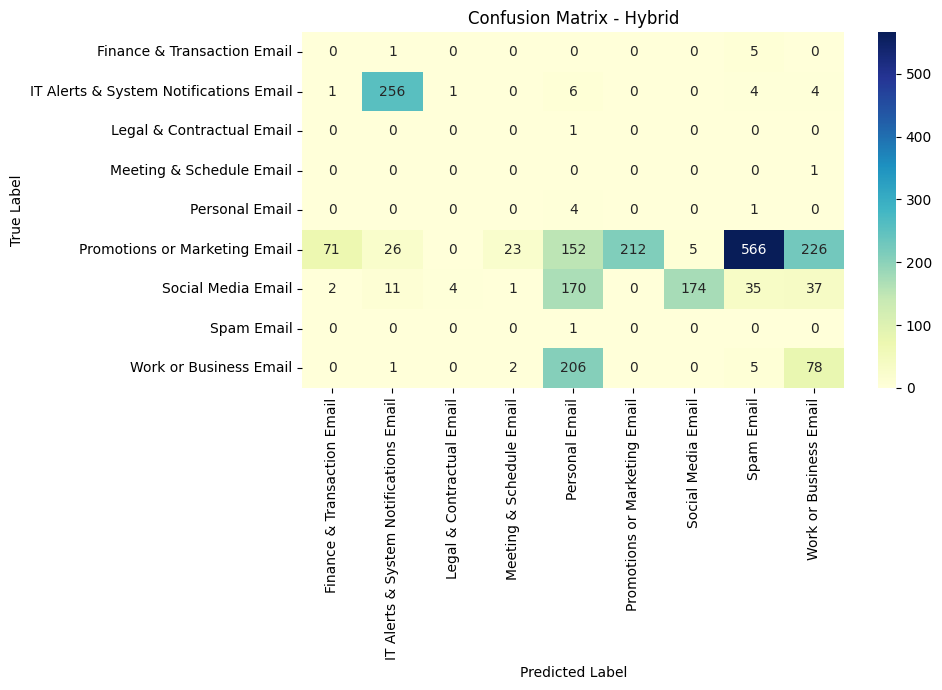


📊 Model Comparison Summary:
                 Model  Accuracy  Precision    Recall  F1-Score
1  Logistic Regression  0.441151   0.320648  0.461094  0.253961
5               Hybrid  0.315606   0.341412  0.286065  0.223744
3              XGBoost  0.282476   0.352450  0.355336  0.217764
0                  SVM  0.233217   0.330089  0.358301  0.185875
2        Random Forest  0.218832   0.349894  0.295179  0.165316
4          Naive Bayes  0.187881   0.351021  0.267895  0.146064


C:\Users\User\AppData\Local\Temp\ipykernel_6332\2400813626.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
C:\Users\User\AppData\Local\Temp\ipykernel_6332\2400813626.py:94: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


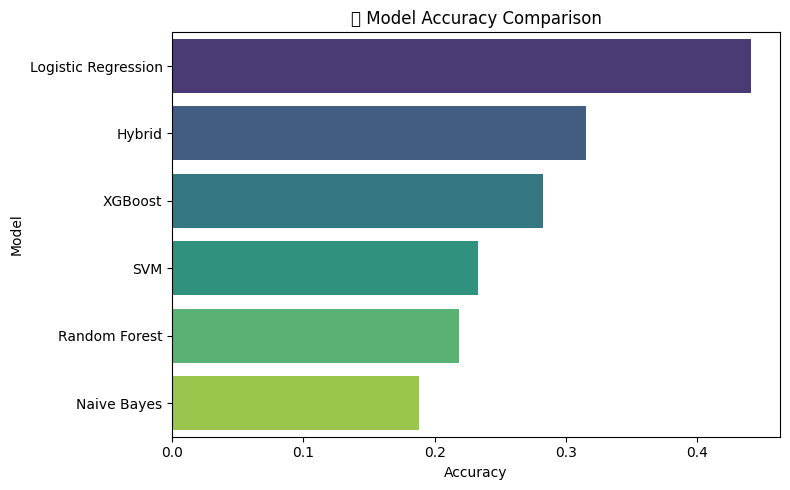

In [1]:
import pandas as pd
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Step 1: Load test data ===
test_data_path = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/emails_202504202357.csv"
df_test = pd.read_csv(test_data_path)

# === Step 2: Load label encoder and BERT embedder ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

encoder_path = os.path.join(save_dir, 'label_encoder.joblib')
embedder_path = os.path.join(save_dir, 'bert_embedder_model')

label_encoder = joblib.load(encoder_path)
embedder = SentenceTransformer(embedder_path)

# === Step 3: Preprocess and generate BERT embeddings ===
df_test['Combined_Text'] = df_test['Subject'].fillna('') + ' ' + df_test['Message'].fillna('')
X_test_text = df_test['Combined_Text'].astype(str).tolist()
X_test_embed = embedder.encode(X_test_text, show_progress_bar=True)

# === Step 4: Encode true labels if available ===
if 'True_Category' in df_test.columns:
    y_true = label_encoder.transform(df_test['True_Category'])

# === Step 5: Define All BERT-based Model Paths ===
model_paths = {
    "SVM": os.path.join(save_dir, 'bert_svm_model.joblib'),
    "Logistic Regression": os.path.join(save_dir, 'bert_lr_model.joblib'),
    "Random Forest": os.path.join(save_dir, 'bert_rf_model.joblib'),
    "XGBoost": os.path.join(save_dir, 'bert_xgb_model.joblib'),
    "Naive Bayes": os.path.join(save_dir, 'bert_nb_model.joblib'),
    "Hybrid": os.path.join(save_dir, 'bert_hybrid_soft_model.joblib')
}

# === Step 6: Evaluate All Models ===
comparison_results = []

for model_name, model_path in model_paths.items():
    print(f"\n🚀 Evaluating: {model_name}")
    model = joblib.load(model_path)
    y_pred = model.predict(X_test_embed)

    # ✅ Identify present classes in test set
    unique_labels = np.unique(y_true)
    target_names = label_encoder.inverse_transform(unique_labels)

    # ✅ Metrics
    acc = accuracy_score(y_true, y_pred)
    report_dict = classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names, output_dict=True)

    # ✅ Append to summary
    comparison_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": report_dict["macro avg"]["precision"],
        "Recall": report_dict["macro avg"]["recall"],
        "F1-Score": report_dict["macro avg"]["f1-score"]
    })

    # ✅ Print report
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names))

    # ✅ Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d",
                xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# === Step 7: Compare All Models ===
comparison_df = pd.DataFrame(comparison_results).sort_values(by="Accuracy", ascending=False)

print("\n📊 Model Comparison Summary:")
print(comparison_df)

# === Step 8: Plot Comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
plt.title("📈 Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# Kaggle dataset

Batches:   0%|          | 0/601 [00:00<?, ?it/s]


🚀 Evaluating: SVM


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.

✅ Accuracy: 0.6719
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.77      0.70      0.73      5554
IT Alerts & System Notifications Email       0.71      0.87      0.78      2404
  Internal Policies & HR Updates Email       0.24      0.40      0.30       141
             Legal & Contractual Email       0.54      0.70      0.61      1390
              Meeting & Schedule Email       0.78      0.81      0.79      2707
                        Personal Email       0.63      0.72      0.67      1691
         Promotions or Marketing Email       0.00      0.00      0.00       779
                Work or Business Email       0.68      0.55      0.60      4556

                             micro avg       0.70      0.67      0.69     19222
                             macro avg       0.54      0.59      0.56     19222
                          weighted avg       0.68      0.67      0.67     19222



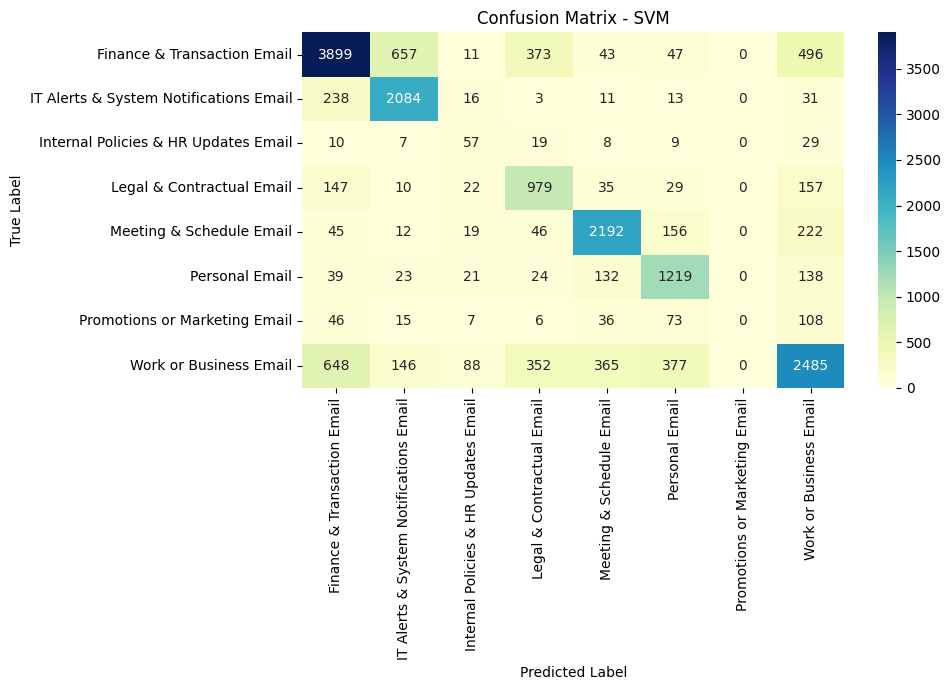


🚀 Evaluating: Logistic Regression
✅ Accuracy: 0.6342
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.74      0.59      0.66      5554
IT Alerts & System Notifications Email       0.60      0.91      0.72      2404
  Internal Policies & HR Updates Email       0.18      0.30      0.23       141
             Legal & Contractual Email       0.53      0.68      0.59      1390
              Meeting & Schedule Email       0.76      0.81      0.78      2707
                        Personal Email       0.61      0.72      0.66      1691
         Promotions or Marketing Email       1.00      0.00      0.00       779
                Work or Business Email       0.67      0.51      0.58      4556

                             micro avg       0.66      0.63      0.65     19222
                             macro avg       0.64      0.57      0.53     19222
                          weighted avg       0.69      0.63     

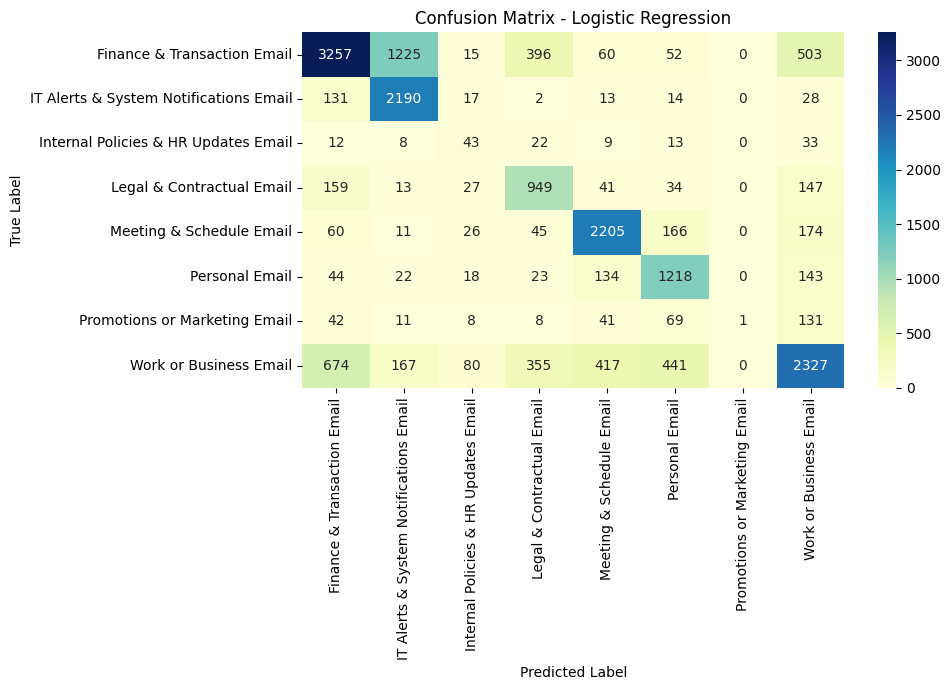


🚀 Evaluating: Random Forest


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.

✅ Accuracy: 0.7319
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.82      0.78      0.80      5554
IT Alerts & System Notifications Email       0.86      0.84      0.85      2404
  Internal Policies & HR Updates Email       0.93      0.66      0.77       141
             Legal & Contractual Email       0.59      0.81      0.68      1390
              Meeting & Schedule Email       0.81      0.83      0.82      2707
                        Personal Email       0.62      0.82      0.71      1691
         Promotions or Marketing Email       0.00      0.00      0.00       779
                Work or Business Email       0.68      0.64      0.66      4556

                             micro avg       0.75      0.73      0.74     19222
                             macro avg       0.66      0.67      0.66     19222
                          weighted avg       0.72      0.73      0.72     19222



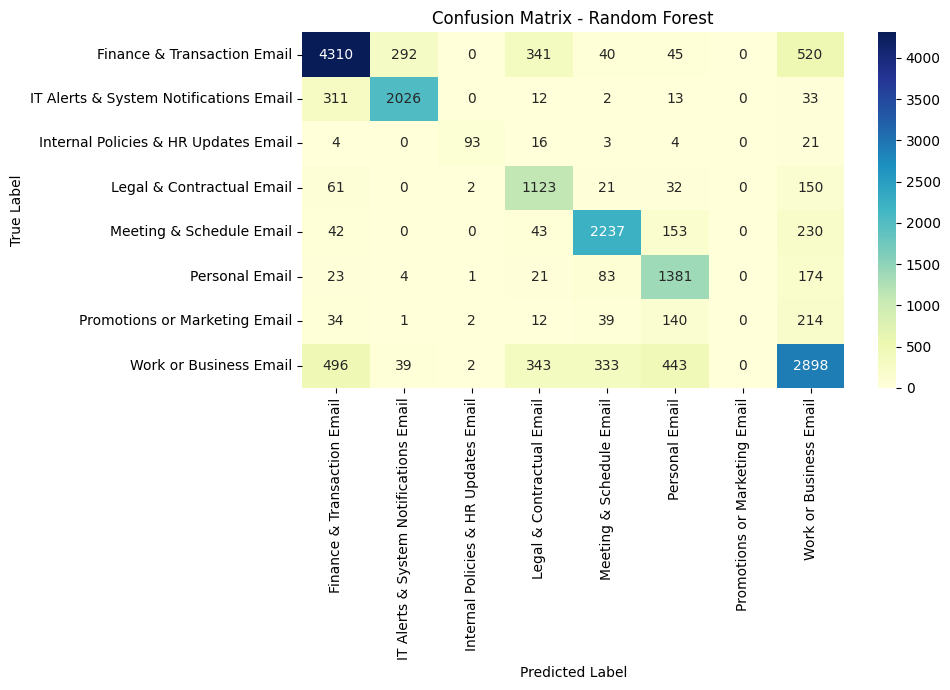


🚀 Evaluating: XGBoost


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.

✅ Accuracy: 0.7264
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.82      0.70      0.75      5554
IT Alerts & System Notifications Email       0.70      0.90      0.79      2404
  Internal Policies & HR Updates Email       0.75      0.69      0.72       141
             Legal & Contractual Email       0.61      0.81      0.70      1390
              Meeting & Schedule Email       0.83      0.85      0.84      2707
                        Personal Email       0.70      0.81      0.75      1691
         Promotions or Marketing Email       0.00      0.00      0.00       779
                Work or Business Email       0.73      0.67      0.69      4556

                             micro avg       0.75      0.73      0.74     19222
                             macro avg       0.64      0.68      0.66     19222
                          weighted avg       0.73      0.73      0.72     19222



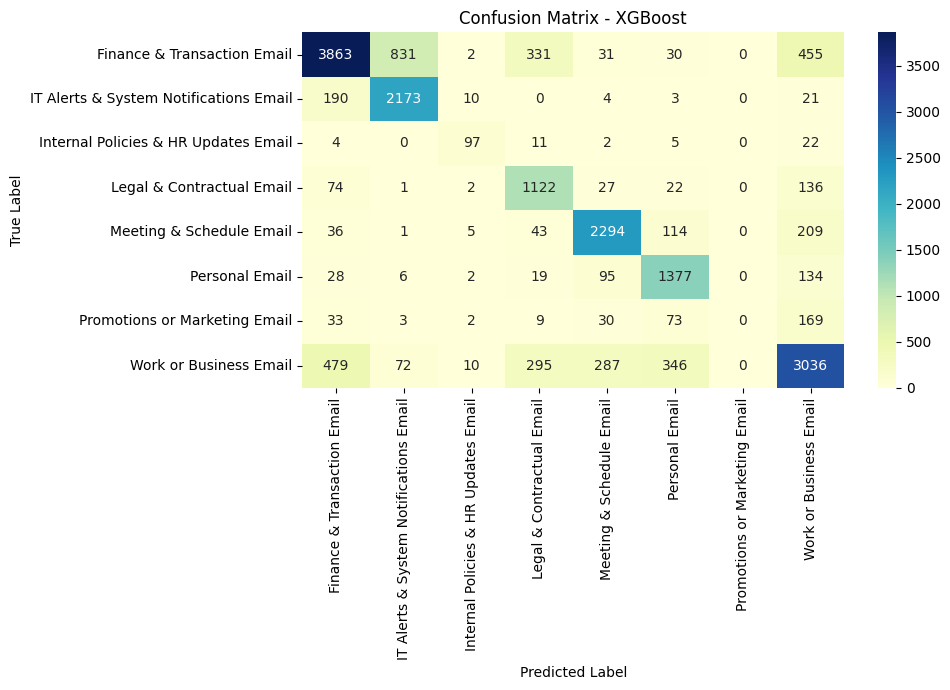


🚀 Evaluating: Naive Bayes
✅ Accuracy: 0.5786
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.66      0.47      0.55      5554
IT Alerts & System Notifications Email       0.53      0.77      0.62      2404
  Internal Policies & HR Updates Email       0.00      0.00      0.00       141
             Legal & Contractual Email       0.53      0.55      0.54      1390
              Meeting & Schedule Email       0.78      0.68      0.73      2707
                        Personal Email       0.55      0.70      0.61      1691
         Promotions or Marketing Email       1.00      0.02      0.05       779
                Work or Business Email       0.51      0.63      0.56      4556

                             micro avg       0.58      0.58      0.58     19222
                             macro avg       0.57      0.48      0.46     19222
                          weighted avg       0.61      0.58      0.57   

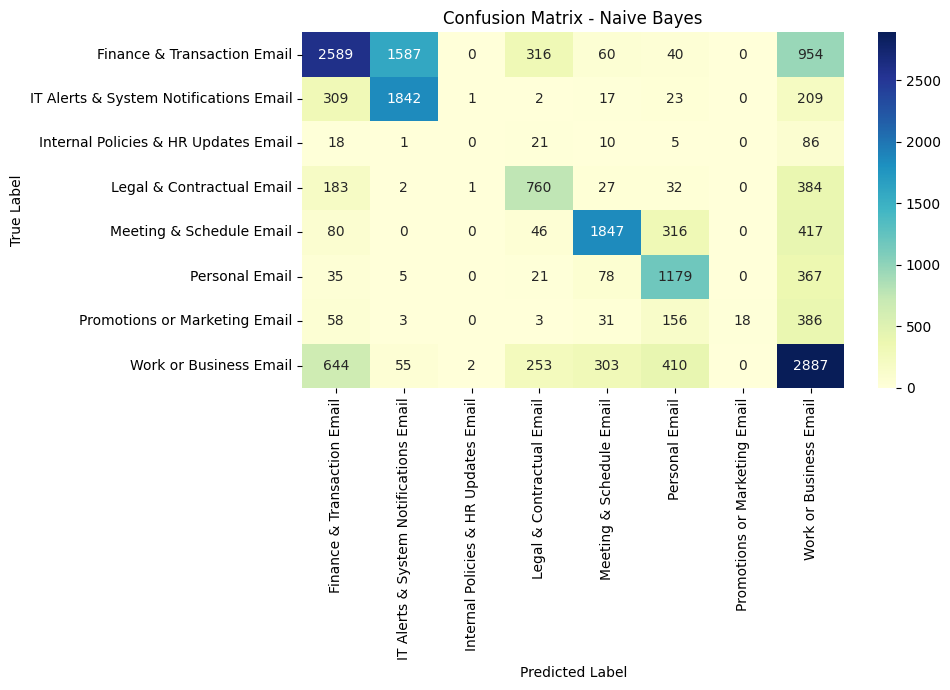


🚀 Evaluating: Hybrid


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.

✅ Accuracy: 0.7234
                                        precision    recall  f1-score   support

           Finance & Transaction Email       0.82      0.71      0.76      5554
IT Alerts & System Notifications Email       0.71      0.91      0.80      2404
  Internal Policies & HR Updates Email       0.58      0.60      0.59       141
             Legal & Contractual Email       0.60      0.79      0.68      1390
              Meeting & Schedule Email       0.81      0.84      0.83      2707
                        Personal Email       0.69      0.80      0.74      1691
         Promotions or Marketing Email       0.00      0.00      0.00       779
                Work or Business Email       0.73      0.64      0.68      4556

                             micro avg       0.75      0.72      0.73     19222
                             macro avg       0.62      0.66      0.64     19222
                          weighted avg       0.72      0.72      0.72     19222



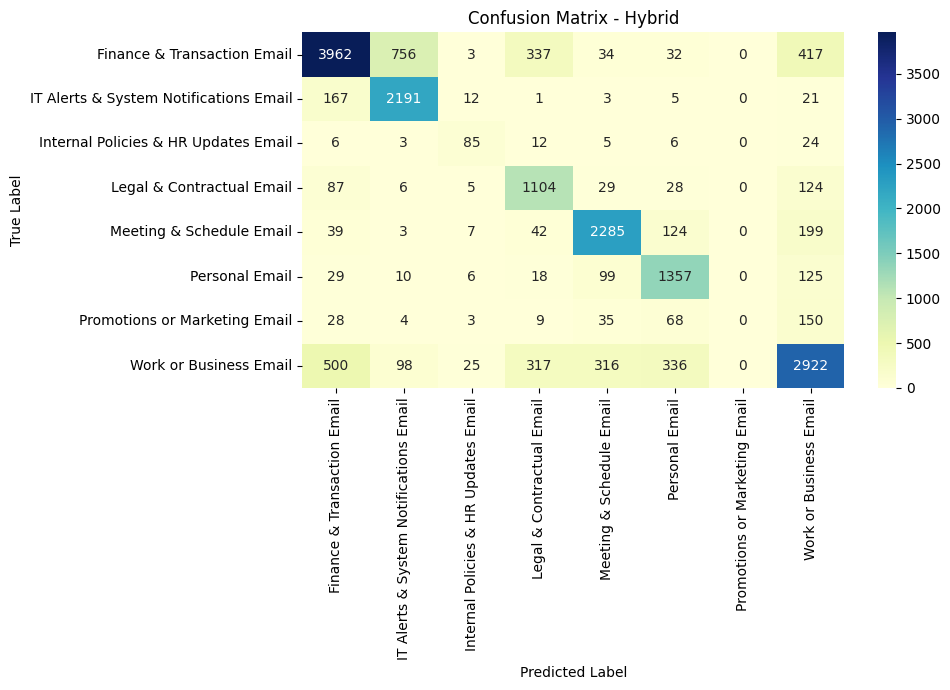


📊 Model Comparison Summary:
                 Model  Accuracy  Precision    Recall  F1-Score
2        Random Forest  0.731870   0.663840  0.670676  0.660423
3              XGBoost  0.726355   0.642124  0.677838  0.655253
5               Hybrid  0.723442   0.619983  0.663723  0.637233
0                  SVM  0.671886   0.542816  0.594192  0.561948
1  Logistic Regression  0.634169   0.635599  0.566498  0.528461
4          Naive Bayes  0.578608   0.569242  0.476930  0.457482


C:\Users\User\AppData\Local\Temp\ipykernel_8088\3076434318.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
C:\Users\User\AppData\Local\Temp\ipykernel_8088\3076434318.py:94: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


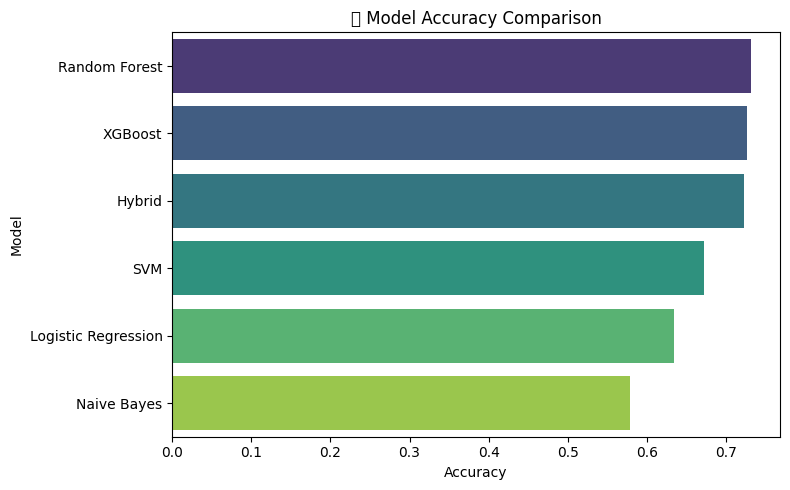

In [27]:
import pandas as pd
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Step 1: Load test data ===
test_data_path = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/email_batch_8_labeled_qwen2.5-LAPTOP-DKNN9H6Q.csv"
df_test = pd.read_csv(test_data_path)

# === Step 2: Load label encoder and BERT embedder ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

encoder_path = os.path.join(save_dir, 'label_encoder.joblib')
embedder_path = os.path.join(save_dir, 'bert_embedder_model')

label_encoder = joblib.load(encoder_path)
embedder = SentenceTransformer(embedder_path)

# === Step 3: Preprocess and generate BERT embeddings ===
df_test['Combined_Text'] = df_test['Subject'].fillna('') + ' ' + df_test['Message'].fillna('')
X_test_text = df_test['Combined_Text'].astype(str).tolist()
X_test_embed = embedder.encode(X_test_text, show_progress_bar=True)

# === Step 4: Encode true labels if available ===
if 'True_Category' in df_test.columns:
    y_true = label_encoder.transform(df_test['True_Category'])

# === Step 5: Define All BERT-based Model Paths ===
model_paths = {
    "SVM": os.path.join(save_dir, 'bert_svm_model.joblib'),
    "Logistic Regression": os.path.join(save_dir, 'bert_lr_model.joblib'),
    "Random Forest": os.path.join(save_dir, 'bert_rf_model.joblib'),
    "XGBoost": os.path.join(save_dir, 'bert_xgb_model.joblib'),
    "Naive Bayes": os.path.join(save_dir, 'bert_nb_model.joblib'),
    "Hybrid": os.path.join(save_dir, 'bert_hybrid_soft_model.joblib')
}

# === Step 6: Evaluate All Models ===
comparison_results = []

for model_name, model_path in model_paths.items():
    print(f"\n🚀 Evaluating: {model_name}")
    model = joblib.load(model_path)
    y_pred = model.predict(X_test_embed)

    # ✅ Identify present classes in test set
    unique_labels = np.unique(y_true)
    target_names = label_encoder.inverse_transform(unique_labels)

    # ✅ Metrics
    acc = accuracy_score(y_true, y_pred)
    report_dict = classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names, output_dict=True)

    # ✅ Append to summary
    comparison_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": report_dict["macro avg"]["precision"],
        "Recall": report_dict["macro avg"]["recall"],
        "F1-Score": report_dict["macro avg"]["f1-score"]
    })

    # ✅ Print report
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names))

    # ✅ Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d",
                xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# === Step 7: Compare All Models ===
comparison_df = pd.DataFrame(comparison_results).sort_values(by="Accuracy", ascending=False)

print("\n📊 Model Comparison Summary:")
print(comparison_df)

# === Step 8: Plot Comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x="Accuracy", y="Model", palette="viridis")
plt.title("📈 Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# Test Real Email Without Category Label

In [20]:
import pandas as pd
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
import os

# === Step 1: Load your real email data (no labels) ===
df_real = pd.read_csv(
    r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/real_world_test_data_no_category.csv"
)

# Combine Subject and Message into one text input
df_real['Combined_Text'] = df_real['Subject'].fillna('') + ' ' + df_real['Message'].fillna('')
X_real_text = df_real['Combined_Text'].astype(str).tolist()

# === Step 2: Load model components ===
save_dir = r"C:/Users/User/OneDrive - Asia Pacific University/APU Final Year Project/FYP Email Project Documents/Email Dataset Python/Model Building/Categorization/Test Bert Results"

# Load BERT embedder and label encoder
embedder = SentenceTransformer(os.path.join(save_dir, 'bert_embedder_model'))
label_encoder = joblib.load(os.path.join(save_dir, 'label_encoder.joblib'))

# Load the trained model (e.g., hybrid voting model)
model = joblib.load(os.path.join(save_dir, 'bert_lr_model.joblib'))

# === Step 3: Generate BERT embeddings ===
X_real_embed = embedder.encode(X_real_text, show_progress_bar=True)

# === Step 4: Predict categories and confidence scores ===
y_pred = model.predict(X_real_embed)
y_proba = model.predict_proba(X_real_embed)

# Assign top 1 prediction
df_real['Predicted_Category'] = label_encoder.inverse_transform(y_pred)
df_real['Confidence'] = np.max(y_proba, axis=1)

# === Step 5: Get Top 3 predictions ===
top_3_indices = np.argsort(-y_proba, axis=1)[:, :3]

# ✅ Apply inverse_transform row-wise for 2D array
top_3_labels = np.array([
    label_encoder.inverse_transform(row)
    for row in top_3_indices
])
top_3_confidence = np.take_along_axis(y_proba, top_3_indices, axis=1)

# Add top 3 predictions to dataframe
df_real['Top_1'] = top_3_labels[:, 0]
df_real['Top_2'] = top_3_labels[:, 1]
df_real['Top_3'] = top_3_labels[:, 2]
df_real['Top_1_Score'] = top_3_confidence[:, 0]
df_real['Top_2_Score'] = top_3_confidence[:, 1]
df_real['Top_3_Score'] = top_3_confidence[:, 2]

# === Step 6: Show prediction preview ===
print(df_real[['Subject', 'Predicted_Category', 'Confidence', 'Top_1', 'Top_2', 'Top_3']].head())

# === Step 7: Save the result to CSV ===
output_path = os.path.join(save_dir, "real_email_predictions_checking.csv")
df_real.to_csv(output_path, index=False)
print(f"\n✅ Predictions saved to:\n{output_path}")

Batches:   0%|          | 0/126 [00:00<?, ?it/s]

                                             Subject  \
0                             You have 1 new message   
1                             You have 1 new message   
2  E-Discovery made easy with Export Emails to Sh...   
3  Instant resume insights with Export Emails to ...   
4  ⏰ Don’t miss your new limited-time opportuniti...   

                       Predicted_Category  Confidence  \
0  IT Alerts & System Notifications Email    0.322129   
1  IT Alerts & System Notifications Email    0.322129   
2                  Work or Business Email    0.740550   
3                  Work or Business Email    0.566764   
4           Promotions or Marketing Email    0.597157   

                                    Top_1  \
0  IT Alerts & System Notifications Email   
1  IT Alerts & System Notifications Email   
2                  Work or Business Email   
3                  Work or Business Email   
4           Promotions or Marketing Email   

                                    Top_2       T